#Bước 0: Chuẩn bị thư viện cần thiết


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


#Bước 1: Hiểu bài toán và hiểu dữ liệu

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Tải các bộ dữ liệu
train_orig = pd.read_csv('/content/drive/MyDrive/fda cuối khóa-20250908T080548Z-1-001/fda cuối khóa/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/fda cuối khóa-20250908T080548Z-1-001/fda cuối khóa/test.csv', parse_dates=['date'])
stores = pd.read_csv('/content/drive/MyDrive/fda cuối khóa-20250908T080548Z-1-001/fda cuối khóa/stores.csv')
oil = pd.read_csv('/content/drive/MyDrive/fda cuối khóa-20250908T080548Z-1-001/fda cuối khóa/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/content/drive/MyDrive/fda cuối khóa-20250908T080548Z-1-001/fda cuối khóa/holidays_events.csv', parse_dates=['date'])
trans=pd.read_csv('/content/drive/MyDrive/fda cuối khóa-20250908T080548Z-1-001/fda cuối khóa/transactions.csv',parse_dates=['date'] )

# Định nghĩa ngày chia
split_date = pd.to_datetime('2016-12-31')

# Chia tập train_orig thành tập huấn luyện và tập validation dựa trên ngày
train = train_orig[train_orig['date'] <= split_date].copy()
val = train_orig[train_orig['date'] > split_date].copy()


print("Đã tải dữ liệu gốc.")
print(f"Đã chia dữ liệu train gốc thành tập huấn luyện (đến {split_date.date()}) và tập validation (sau {split_date.date()}):")
print("Kích thước tập huấn luyện:", train.shape)
print("Kích thước tập validation:", val.shape)

display(train.head())
display(val.head())

# Kiểm tra ngày cuối cùng của train và ngày đầu tiên của val
print("\nNgày cuối cùng của tập huấn luyện:")
display(train['date'].max())
print("Ngày đầu tiên của tập validation:")
display(val['date'].min())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đã tải dữ liệu gốc.
Đã chia dữ liệu train gốc thành tập huấn luyện (đến 2016-12-31) và tập validation (sau 2016-12-31):
Kích thước tập huấn luyện: (2596374, 6)
Kích thước tập validation: (404514, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,id,date,store_nbr,family,sales,onpromotion
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0
2596375,2596375,2017-01-01,1,BABY CARE,0.0,0
2596376,2596376,2017-01-01,1,BEAUTY,0.0,0
2596377,2596377,2017-01-01,1,BEVERAGES,0.0,0
2596378,2596378,2017-01-01,1,BOOKS,0.0,0



Ngày cuối cùng của tập huấn luyện:


Timestamp('2016-12-31 00:00:00')

Ngày đầu tiên của tập validation:


Timestamp('2017-01-01 00:00:00')

##1.1 Gộp bảng store vào train/val


In [ ]:
# Gộp bảng train và val với stores
train_merged = pd.merge(train, stores, on='store_nbr', how='left')
val_merged = pd.merge(val, stores, on='store_nbr', how='left') # Gộp val với stores


# Hiển thị vài dòng đầu của các bảng đã gộp
print("Train Merged Head sau khi gộp với stores:")
display(train_merged.head())

print("\nVal Merged Head sau khi gộp với stores:")
display(val_merged.head())

Train Merged Head sau khi gộp với stores:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13



Val Merged Head sau khi gộp với stores:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


##1.2 Gộp bảng oil vào train/val

In [ ]:
# Gộp train_merged với oil
train_merged = pd.merge(train_merged, oil, on='date', how='left')

# Gộp val_merged với oil
val_merged = pd.merge(val_merged, oil, on='date', how='left')

# Hiển thị phần đầu của các dataframe đã gộp
print("Train Merged Head sau khi gộp với oil:")
display(train_merged.head())

print("\nVal Merged Head sau khi gộp với oil:")
display(val_merged.head())

Train Merged Head sau khi gộp với oil:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN



Val Merged Head sau khi gộp với oil:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


##1.3 Xử lí dữ liệu bảng holiday-event trước khi hợp nhất



###1.3.1 Các ngày lễ được lùi sang cuối tuần

In [ ]:
# Lọc các dòng có 'type' là 'Transfer'
transfer_holidays = holidays[holidays['type'] == 'Transfer']

# Lấy thứ trong tuần cho các ngày lễ loại 'Transfer'
transfer_weekdays = transfer_holidays['date'].dt.day_name()

print("Thứ trong tuần cho các ngày lễ loại 'Transfer':")
display(transfer_weekdays)

# Lọc các dòng có 'transferred' là True
transferred_holidays = holidays[holidays['transferred'] == True]

# Lấy thứ trong tuần cho các ngày lễ đã chuyển đổi
transferred_weekdays = transferred_holidays['date'].dt.day_name()

print("\nThứ trong tuần cho các ngày lễ đã chuyển đổi:")
display(transferred_weekdays)

Thứ trong tuần cho các ngày lễ loại 'Transfer':


,date
20,Friday
73,Friday
136,Friday
256,Friday
265,Sunday
269,Friday
298,Monday
304,Thursday
313,Friday
325,Friday



Thứ trong tuần cho các ngày lễ đã chuyển đổi:


,date
19,Tuesday
72,Wednesday
135,Thursday
255,Tuesday
266,Monday
268,Wednesday
297,Sunday
303,Wednesday
312,Wednesday
324,Thursday


### 1.3.2 Sửa tên cột type bị trùng



In [ ]:
# Tìm các cột trùng tên giữa train_merged và holidays
common_columns = list(set(train_merged.columns) & set(holidays.columns))

print("Các cột trùng tên giữa train_merged và holidays:")
display(common_columns)

Các cột trùng tên giữa train_merged và holidays:


['type', 'date']

In [ ]:
print("Các cột của bảng train_merged:")
display(train_merged.head())
print("Các cột trong bảng holidays:")
display(holidays.head())

Các cột của bảng train_merged:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


Các cột trong bảng holidays:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
holidays = holidays.rename(columns={'type': 'type_hd'})
display(holidays.head())

,date,type_hd,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


###1.3.3 Xóa các hàng có transferred = True

In [ ]:
# Xóa hàng có 'transferred' là True
holidays = holidays[holidays['transferred'] == False]

print("Holiyday head after removing transferred holidays:")
display(holidays.head())

Holiyday head after removing transferred holidays:


,date,type_hd,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


###1.3.4 Gộp bảng holidays_events vào train/val

In [ ]:
# Hợp nhất train_merged với holidays
train_merged = pd.merge(train_merged, holidays, on='date', how='left')

# Hợp nhất val_merged với holidays
val_merged = pd.merge(val_merged, holidays, on='date', how='left')

# Điền các giá trị NaN trong các cột ngày lễ mới bằng "No Holiday"
for col in holidays.columns:
    if col != 'date':
        train_merged[col] = train_merged[col].fillna('No Holiday')
        val_merged[col] = val_merged[col].fillna('No Holiday')

# Hiển thị phần đầu của các dataframe đã hợp nhất
print("Train Merged Head sau khi gộp với holidays:")
display(train_merged.head())

print("\nVal Merged Head sau khi gộp với holidays:")
display(val_merged.head())

Train Merged Head sau khi gộp với holidays:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False



Val Merged Head sau khi gộp với holidays:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,transferred
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday


In [ ]:
# Xóa cột 'transferred' khỏi cả train_merged và val_merged
train_merged = train_merged.drop('transferred', axis=1)
val_merged = val_merged.drop('transferred', axis=1)

# Hiển thị phần đầu của các dataframes
print("Train Merged Head after dropping 'transferred' column:")
display(train_merged.head())
display(train_merged.tail())

print("Val Merged Head after dropping 'transferred' column:")
display(val_merged.head())
display(val_merged.tail())

Train Merged Head after dropping 'transferred' column:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
2642701,2596369,2016-12-31,9,POULTRY,687.853,1,Quito,Pichincha,B,6,NaN,Additional,National,Ecuador,Primer dia del ano-1
2642702,2596370,2016-12-31,9,PREPARED FOODS,100.405,1,Quito,Pichincha,B,6,NaN,Additional,National,Ecuador,Primer dia del ano-1
2642703,2596371,2016-12-31,9,PRODUCE,3091.356,3,Quito,Pichincha,B,6,NaN,Additional,National,Ecuador,Primer dia del ano-1
2642704,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,Quito,Pichincha,B,6,NaN,Additional,National,Ecuador,Primer dia del ano-1
2642705,2596373,2016-12-31,9,SEAFOOD,13.000,2,Quito,Pichincha,B,6,NaN,Additional,National,Ecuador,Primer dia del ano-1


Val Merged Head after dropping 'transferred' column:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
411637,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba
411638,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba
411639,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba
411640,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba
411641,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba


### 1.3.5 Hợp nhất ngày lễ dựa trên phạm vi

In [ ]:
# Hàm để hợp nhất ngày lễ dựa trên điều kiện (phiên bản tối ưu hiệu suất)
def merge_holidays_conditional(df, holidays_df):
    # Đảm bảo cột date là datetime để hợp nhất
    df['date'] = pd.to_datetime(df['date'])
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])

    # Tạo các cột tạm thời cho từng loại ngày lễ
    national_holidays = holidays_df[holidays_df['locale'] == 'National'].copy()
    national_holidays = national_holidays[['date', 'type_hd', 'locale', 'locale_name', 'description']].rename(columns={'type_hd': 'type_hd_national', 'locale': 'locale_national', 'locale_name': 'locale_name_national', 'description': 'description_national'})

    regional_holidays = holidays_df[holidays_df['locale'] == 'Regional'].copy()
    regional_holidays = regional_holidays[['date', 'locale_name', 'type_hd', 'locale', 'description']].rename(columns={'locale_name': 'state', 'type_hd': 'type_hd_regional', 'locale': 'locale_regional', 'description': 'description_regional'})

    local_holidays = holidays_df[holidays_df['locale'] == 'Local'].copy()
    local_holidays = local_holidays[['date', 'locale_name', 'type_hd', 'locale', 'description']].rename(columns={'locale_name': 'city', 'type_hd': 'type_hd_local', 'locale': 'locale_local', 'description': 'description_local'})


    # Hợp nhất các loại ngày lễ vào DataFrame chính
    df = pd.merge(df, national_holidays, on='date', how='left')
    df = pd.merge(df, regional_holidays, on=['date', 'state'], how='left')
    df = pd.merge(df, local_holidays, on=['date', 'city'], how='left')

    # Khởi tạo các cột ngày lễ cuối cùng
    df['type_hd'] = 'No Holiday'
    df['locale'] = 'No Holiday'
    df['locale_name'] = 'No Holiday'
    df['description'] = 'No Holiday'

    # Áp dụng logic ưu tiên mới
    conditions = [
        # Case 5: Local, Regional, National overlap
        df['type_hd_local'].notna() & df['type_hd_regional'].notna() & df['type_hd_national'].notna(),
        # Case 2: Local and National overlap
        df['type_hd_local'].notna() & df['type_hd_national'].notna(),
         # Case 3: Regional and National overlap
        df['type_hd_regional'].notna() & df['type_hd_national'].notna(),
        # Case 1 part 1: Local and Regional overlap (Local within Regional is not handled explicitly here, needs more complex logic if required)
        df['type_hd_local'].notna() & df['type_hd_regional'].notna(),
        # Default priority based on locale scope if no specific overlap
        df['type_hd_local'].notna(),
        df['type_hd_regional'].notna(),
        df['type_hd_national'].notna()
    ]

    # Define the choices based on the conditions
    choices_type_hd = [
        'Bonus Event', # Case 5
        'Bonus Event', # Case 2
        'Bonus Event', # Case 3
        'Bonus Event', # Case 1 part 1
        df['type_hd_local'], # Default Local
        df['type_hd_regional'], # Default Regional
        df['type_hd_national'] # Default National
    ]

    choices_locale = [
        'Bonus Event', # Case 5
        'Bonus Event', # Case 2
        'Bonus Event', # Case 3
        'Bonus Event', # Case 1 part 1
        df['locale_local'], # Default Local
        df['locale_regional'], # Default Regional
        df['locale_national'] # Default National
    ]
    # locale_name: for local is city, for regional is state
    choices_locale_name = [
        'Bonus Event', # Case 5
        'Bonus Event', # Case 2
        'Bonus Event', # Case 3
        'Bonus Event', # Case 1 part 1
        df['city'], # Default Local (city)
        df['state'], # Default Regional (state)
        df['locale_name_national'] # Default National (locale_name_national)
    ]
    choices_description = [
        'Bonus Event', # Case 5
        'Bonus Event', # Case 2
        'Bonus Event', # Case 3
        'Bonus Event', # Case 1 part 1
        df['description_local'], # Default Local
        df['description_regional'], # Default Regional
        df['description_national'] # Default National
    ]


    df['type_hd'] = np.select(conditions, choices_type_hd, default='No Holiday')
    df['locale'] = np.select(conditions, choices_locale, default='No Holiday')
    df['locale_name'] = np.select(conditions, choices_locale_name, default='No Holiday')
    df['description'] = np.select(conditions, choices_description, default='No Holiday')


    # Xóa các cột tạm thời đã hợp nhất
    cols_to_drop = [col for col in df.columns if col.endswith(('_national', '_regional', '_local'))]
    df = df.drop(columns=cols_to_drop)


    return df

# Áp dụng hàm hợp nhất cho train_merged và val_merged
train_merged = merge_holidays_conditional(train_merged, holidays)
val_merged = merge_holidays_conditional(val_merged, holidays)


# Hiển thị một vài dòng đầu của các bảng đã hợp nhất
print("\nTrain Merged Head after conditional holiday merge (optimized):")
display(train_merged.head())

print("\nVal Merged Head after conditional holiday merge (optimized):")
display(val_merged.head())


Train Merged Head after conditional holiday merge (optimized):


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano



Val Merged Head after conditional holiday merge (optimized):


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday


In [ ]:
# Lọc train_merged cho các dòng có 'Bonus Event' trong cột 'type_hd'
bonus_event_data = train_merged[train_merged['type_hd'] == 'Bonus Event']

print("Dữ liệu cho các ngày có 'Bonus Event':")
display(bonus_event_data)

Dữ liệu cho các ngày có 'Bonus Event':


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
234366,233904,2013-05-12,22,AUTOMOTIVE,0.000,0,Puyo,Pastaza,C,7,NaN,Bonus Event,Bonus Event,Bonus Event,Bonus Event
234367,233904,2013-05-12,22,AUTOMOTIVE,0.000,0,Puyo,Pastaza,C,7,NaN,Bonus Event,Bonus Event,Bonus Event,Bonus Event
234368,233905,2013-05-12,22,BABY CARE,0.000,0,Puyo,Pastaza,C,7,NaN,Bonus Event,Bonus Event,Bonus Event,Bonus Event
234369,233905,2013-05-12,22,BABY CARE,0.000,0,Puyo,Pastaza,C,7,NaN,Bonus Event,Bonus Event,Bonus Event,Bonus Event
234370,233906,2013-05-12,22,BEAUTY,0.000,0,Puyo,Pastaza,C,7,NaN,Bonus Event,Bonus Event,Bonus Event,Bonus Event
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640853,2580927,2016-12-22,25,PRODUCE,1514.369,7,Salinas,Santa Elena,D,1,51.98,Bonus Event,Bonus Event,Bonus Event,Bonus Event
2640854,2580928,2016-12-22,25,SCHOOL AND OFFICE SUPPLIES,0.000,0,Salinas,Santa Elena,D,1,51.98,Bonus Event,Bonus Event,Bonus Event,Bonus Event
2640855,2580928,2016-12-22,25,SCHOOL AND OFFICE SUPPLIES,0.000,0,Salinas,Santa Elena,D,1,51.98,Bonus Event,Bonus Event,Bonus Event,Bonus Event
2640856,2580929,2016-12-22,25,SEAFOOD,2.000,0,Salinas,Santa Elena,D,1,51.98,Bonus Event,Bonus Event,Bonus Event,Bonus Event


In [ ]:
train_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2657490 entries, 0 to 2657489
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           2657490 non-null  int64         
 1   date         2657490 non-null  datetime64[ns]
 2   store_nbr    2657490 non-null  int64         
 3   family       2657490 non-null  object        
 4   sales        2657490 non-null  float64       
 5   onpromotion  2657490 non-null  int64         
 6   city         2657490 non-null  object        
 7   state        2657490 non-null  object        
 8   type         2657490 non-null  object        
 9   cluster      2657490 non-null  int64         
 10  dcoilwtico   1826550 non-null  float64       
 11  type_hd      2657490 non-null  object        
 12  locale       2657490 non-null  object        
 13  locale_name  2657490 non-null  object        
 14  description  2657490 non-null  object        
dtypes: datetime64[n

In [ ]:
# Xóa các hàng trùng lặp dựa trên 'id' và 'date'
# Việc này giúp đảm bảo mỗi sự kiện bán hàng gốc chỉ xuất hiện một lần
train_merged = train_merged.drop_duplicates(subset=['id', 'date'], keep='first').copy()
val_merged = val_merged.drop_duplicates(subset=['id', 'date'], keep='first').copy()

print("Đã xóa các hàng trùng lặp trong train_merged và val_merged.")

# Hiển thị thông tin để kiểm tra số lượng hàng sau khi xóa trùng lặp
print("\nThông tin train_merged sau khi xóa trùng lặp:")
train_merged.info(show_counts=True)

print("\nThông tin val_merged sau khi xóa trùng lặp:")
val_merged.info(show_counts=True)

Đã xóa các hàng trùng lặp trong train_merged và val_merged.

Thông tin train_merged sau khi xóa trùng lặp:
<class 'pandas.core.frame.DataFrame'>
Index: 2596374 entries, 0 to 2657489
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           2596374 non-null  int64         
 1   date         2596374 non-null  datetime64[ns]
 2   store_nbr    2596374 non-null  int64         
 3   family       2596374 non-null  object        
 4   sales        2596374 non-null  float64       
 5   onpromotion  2596374 non-null  int64         
 6   city         2596374 non-null  object        
 7   state        2596374 non-null  object        
 8   type         2596374 non-null  object        
 9   cluster      2596374 non-null  int64         
 10  dcoilwtico   1796256 non-null  float64       
 11  type_hd      2596374 non-null  object        
 12  locale       2596374 non-null  object        
 13  locale_name  25

###

In [ ]:
print("Các giá trị duy nhất trong cột 'type_hd':")
display(train_merged['type_hd'].unique())


Các giá trị duy nhất trong cột 'type_hd':


array(['Holiday', 'No Holiday', 'Work Day', 'Additional', 'Event',
       'Bonus Event', 'Transfer', 'Bridge'], dtype=object)

In [ ]:
print("Các giá trị duy nhất trong cột 'type_hd':")
display(holidays['type_hd'].unique())

print("\nCác giá trị duy nhất trong cột 'description':")
display(holidays['description'].unique())

Các giá trị duy nhất trong cột 'type_hd':


array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)


Các giá trị duy nhất trong cột 'description':


array(['Fundacion de Manta', 'Provincializacion de Cotopaxi',
       'Fundacion de Cuenca', 'Cantonizacion de Libertad',
       'Cantonizacion de Riobamba', 'Cantonizacion del Puyo',
       'Cantonizacion de Guaranda', 'Provincializacion de Imbabura',
       'Cantonizacion de Latacunga', 'Fundacion de Machala',
       'Fundacion de Santo Domingo', 'Cantonizacion de El Carmen',
       'Cantonizacion de Cayambe', 'Fundacion de Esmeraldas',
       'Primer Grito de Independencia', 'Fundacion de Riobamba',
       'Fundacion de Ambato', 'Fundacion de Ibarra',
       'Cantonizacion de Quevedo', 'Traslado Independencia de Guayaquil',
       'Dia de Difuntos', 'Independencia de Cuenca',
       'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia de Guaranda',
       'Independencia de Latacunga', 'Independencia de Ambato',
       'Fundacion de Quito-1', 'Fundacion de Quito', 'Fundacion de Loja',
       'Navidad-4', 'Cantonizacion de Salinas', 'Navidad-3', 

###1.3.6 Tạo cột is_earthquake cho sự kiện động đất 2016 (Terremoto Manabi)

In [ ]:
# Tạo cột is_earthquake trong train_merged
train_merged['is_earthquake'] = train_merged['description'].apply(lambda x: 1 if 'Terremoto Manabi' in str(x) else 0)

# Tạo cột is_earthquake trong val_merged
val_merged['is_earthquake'] = val_merged['description'].apply(lambda x: 1 if 'Terremoto Manabi' in str(x) else 0)

print("Đã tạo cột 'is_earthquake' trong train_merged và val_merged.")

# Hiển thị một vài dòng đầu để kiểm tra cột mới
display(train_merged.head())
display(val_merged.head())

Đã tạo cột 'is_earthquake' trong train_merged và val_merged.


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0


###1.3.7 Tạo cột WORLD CUP 2014

In [ ]:
# Tạo cột is_world_cup trong train_merged
train_merged['world_cup'] = train_merged['description'].apply(lambda x: 1 if 'Mundial de futbol Brasil:' in str(x) else 0)

# Tạo cột is_world_cup trong val_merged
val_merged['world_cup'] = val_merged['description'].apply(lambda x: 1 if 'Mundial de futbol Brasil:' in str(x) else 0)

print("Đã tạo cột 'world_cup' trong train_merged và val_merged.")

# Hiển thị một vài dòng đầu để kiểm tra cột mới
display(train_merged.head())
display(val_merged.head())

Đã tạo cột 'world_cup' trong train_merged và val_merged.


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0


##1.4 Tạo cột has sales để chuẩn bị cho mô hình phân loại


In [ ]:
# Tạo biến mục tiêu nhị phân 'has_sales'
# Dùng .copy() để tránh SettingWithCopyWarning
train_merged['has_sales'] = (train_merged['sales'] > 0).astype(int)
val_merged['has_sales'] = (val_merged['sales'] > 0).astype(int)
# test_merged không có cột 'sales' ban đầu, nên chúng ta sẽ tạo cột này khi áp dụng tiền xử lý cho test riêng
# For now, we just confirm test_merged does not need this step yet as it lacks 'sales']

print("Đã thêm cột 'has_sales' vào train_merged và val_merged.")
display(train_merged.head())
display(val_merged.head())

Đã thêm cột 'has_sales' vào train_merged và val_merged.


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup,has_sales
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup,has_sales
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0


##1.5 Tổng quan về dữ liệu sau khi gộp

In [ ]:
train_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2596374 entries, 0 to 2657489
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   id             2596374 non-null  int64         
 1   date           2596374 non-null  datetime64[ns]
 2   store_nbr      2596374 non-null  int64         
 3   family         2596374 non-null  object        
 4   sales          2596374 non-null  float64       
 5   onpromotion    2596374 non-null  int64         
 6   city           2596374 non-null  object        
 7   state          2596374 non-null  object        
 8   type           2596374 non-null  object        
 9   cluster        2596374 non-null  int64         
 10  dcoilwtico     1796256 non-null  float64       
 11  type_hd        2596374 non-null  object        
 12  locale         2596374 non-null  object        
 13  locale_name    2596374 non-null  object        
 14  description    2596374 non-null  object

###1.5.1 Xếp hạng doanh thu theo cửa hàng và theo danh mục hàng

In [ ]:
# Tính tổng doanh thu theo cửa hàng và xếp hạng
store_sales_ranking = train_merged.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).reset_index()

# Hợp nhất với dataframe stores để thêm thông tin thành phố và tiểu bang
store_sales_ranking = pd.merge(store_sales_ranking, stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')

print("Bảng xếp hạng doanh thu theo cửa hàng:")
# Định dạng lại cột sales để dễ đọc
store_sales_ranking['sales'] = store_sales_ranking['sales'].map('{:,.2f}'.format)
display(store_sales_ranking)

# Tính tổng doanh thu theo ngành hàng và xếp hạng
family_sales_ranking = train_merged.groupby('family')['sales'].sum().sort_values(ascending=False)

print("\nBảng xếp hạng doanh thu theo ngành hàng:")
# Định dạng lại cột sales để dễ đọc
display(family_sales_ranking.map('{:,.2f}'.format))

Bảng xếp hạng doanh thu theo cửa hàng:


,store_nbr,sales,city,state
0,44,"51,597,433.27",Quito,Pichincha
1,45,"44,842,089.11",Quito,Pichincha
2,47,"41,879,191.67",Quito,Pichincha
3,3,"41,769,569.83",Quito,Pichincha
4,49,"35,035,847.31",Quito,Pichincha
5,46,"34,658,737.97",Quito,Pichincha
6,48,"29,916,983.87",Quito,Pichincha
7,51,"27,547,204.40",Guayaquil,Guayas
8,8,"25,243,478.70",Quito,Pichincha
9,50,"23,737,792.70",Ambato,Tungurahua



Bảng xếp hạng doanh thu theo ngành hàng:


,sales
family,
GROCERY I,"286,321,797.73"
BEVERAGES,"173,001,894.00"
PRODUCE,"93,429,277.79"
CLEANING,"82,022,473.00"
DAIRY,"53,032,009.00"
BREAD/BAKERY,"35,293,578.96"
POULTRY,"27,061,094.77"
MEATS,"26,545,568.12"
PERSONAL CARE,"20,562,395.00"


###1.5.2 Tổng quan ảnh hưởng của động đất năm 2016

In [ ]:
train_2016 = train_merged[train_merged['date'].dt.year == 2016]
display(train_2016.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup,has_sales
1976238,1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
1976239,1945945,2016-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
1976240,1945946,2016-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
1976241,1945947,2016-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
1976242,1945948,2016-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0


In [ ]:
daily_sales_2016 = train_2016.groupby('date')['sales'].sum().reset_index()
display(daily_sales_2016.head())

,date,sales
0,2016-01-01,1.643339e+04
1,2016-01-02,1.066677e+06
2,2016-01-03,1.226736e+06
3,2016-01-04,9.559569e+05
4,2016-01-05,8.353204e+05


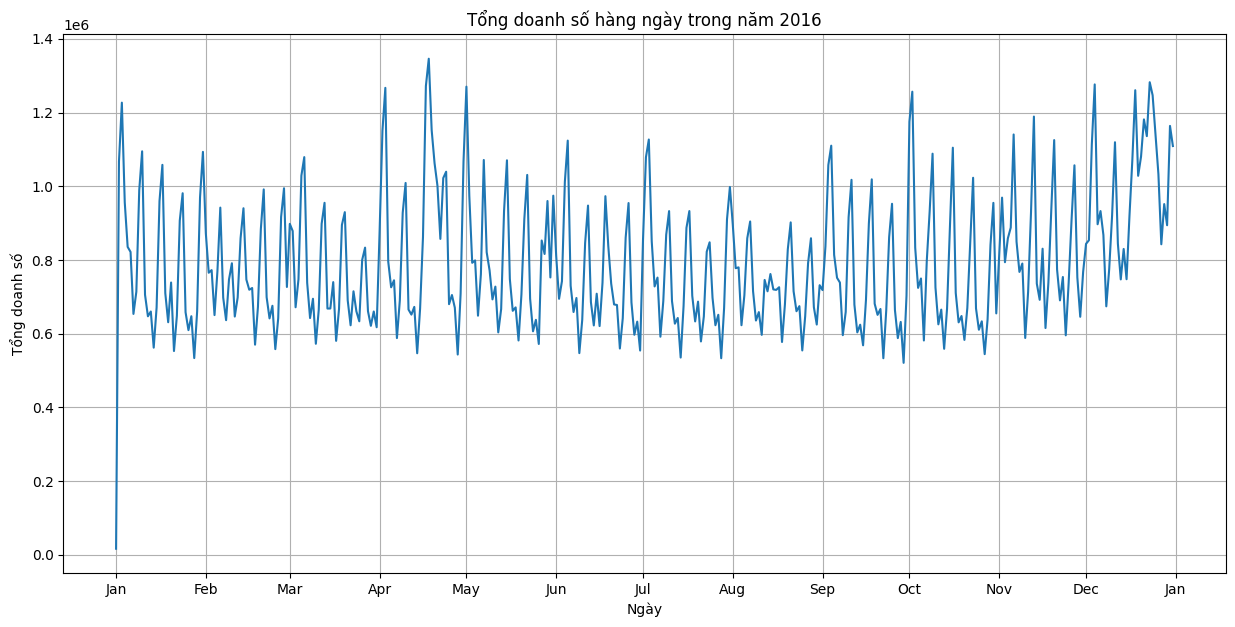

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_sales_2016, x='date', y='sales')
plt.title('Tổng doanh số hàng ngày trong năm 2016')
plt.xlabel('Ngày')
plt.ylabel('Tổng doanh số')
plt.grid(True)

# Set x-axis major locator to months and format to display month abbreviation
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()

###1.5.3 Tổng quan tác động của giáng sinh năm 2014

In [ ]:
train_2014 = train_merged[train_merged['date'].dt.year == 2014]
display(train_2014.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup,has_sales
657558,648648,2014-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
657559,648649,2014-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
657560,648650,2014-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
657561,648651,2014-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0
657562,648652,2014-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,0,0,0


In [ ]:
daily_sales_2014 = train_2014.groupby('date')['sales'].sum().reset_index()
display(daily_sales_2014.head())

,date,sales
0,2014-01-01,8602.065404
1,2014-01-02,801011.226041
2,2014-01-03,680672.845603
3,2014-01-04,936628.886604
4,2014-01-05,949618.788940


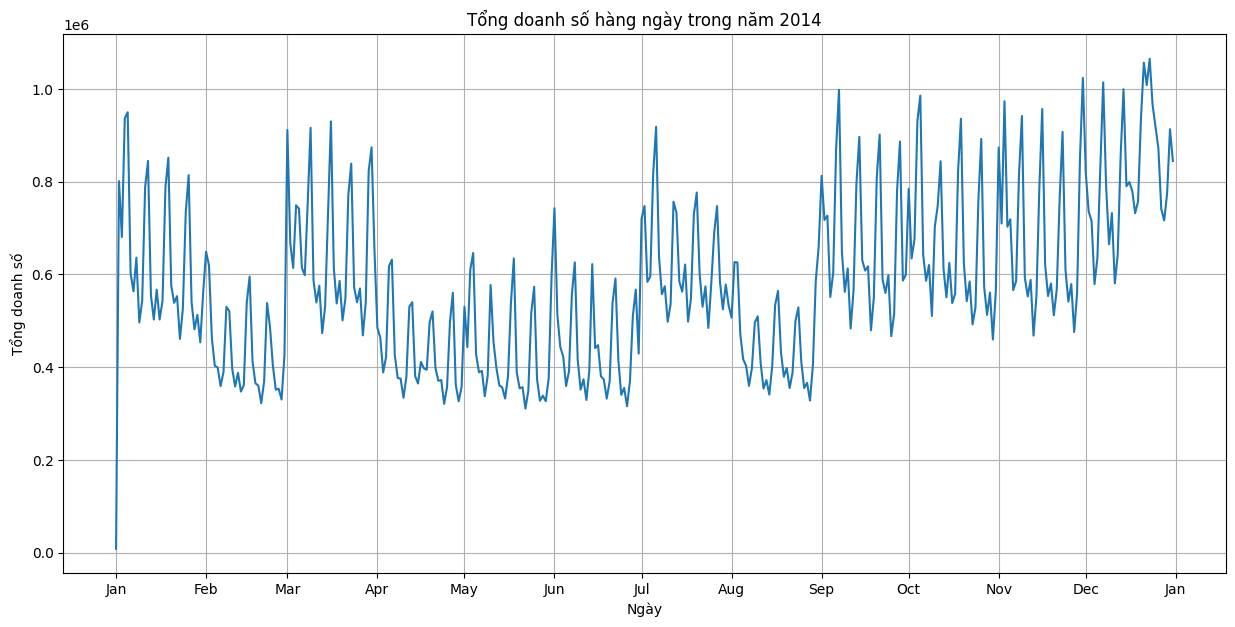

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_sales_2014, x='date', y='sales')
plt.title('Tổng doanh số hàng ngày trong năm 2014')
plt.xlabel('Ngày')
plt.ylabel('Tổng doanh số')
plt.grid(True)

# Set x-axis major locator to months and format to display month abbreviation
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()

##1.5.4 Tổng quan doanh số theo tháng




In [ ]:
train_merged['month'] = train_merged['date'].dt.month
monthly_sales = train_merged.groupby('month')['sales'].sum().reset_index()
display(monthly_sales.head())

,month,sales
0,1,6.811399e+07
1,2,5.738712e+07
2,3,7.052447e+07
3,4,6.477281e+07
4,5,6.748729e+07


#### Trực quan hóa: Vẽ biểu đồ đường thể hiện tổng doanh số hàng tháng theo thời gian.


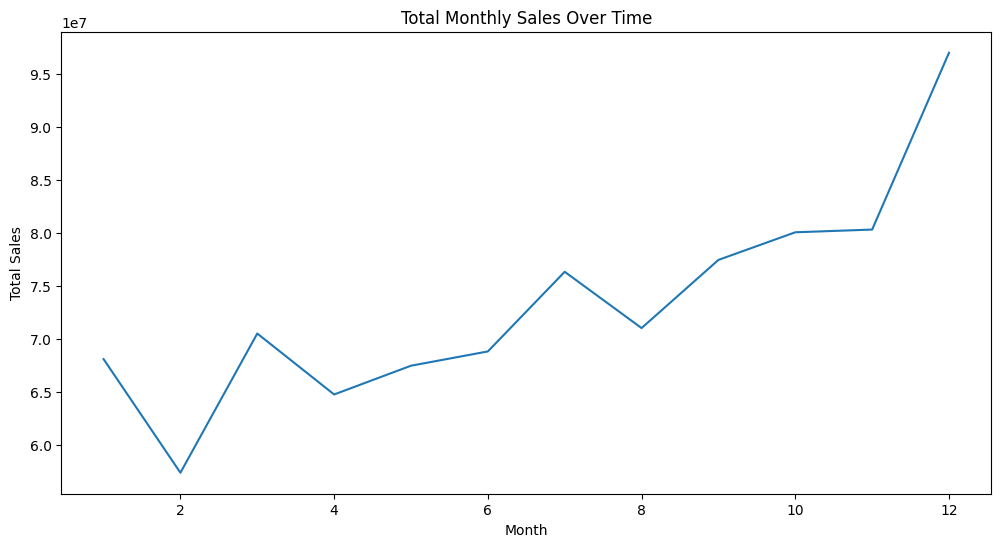

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales')
plt.title('Total Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

###1.5.5 Tổng quan tác động của promotion

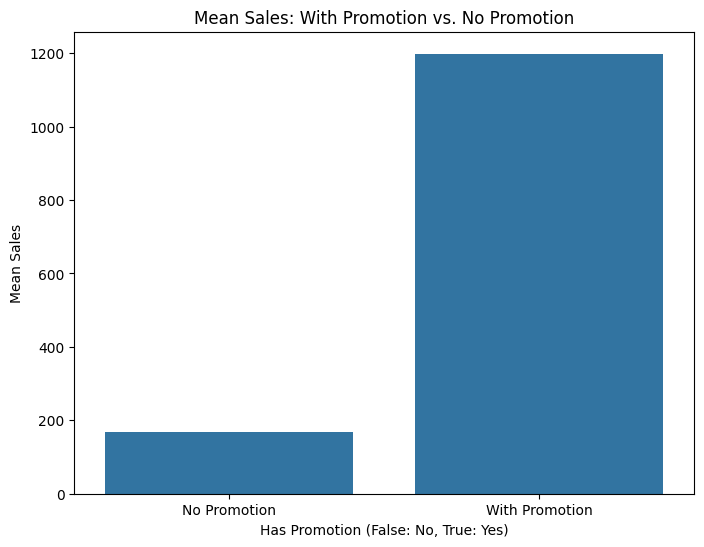

In [ ]:
# Create a new column indicating whether there is any promotion
train_merged['has_promotion'] = train_merged['onpromotion'] > 0

# Calculate the mean sales for each group (with and without promotion)
promotion_impact = train_merged.groupby('has_promotion')['sales'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(data=promotion_impact, x='has_promotion', y='sales')
plt.title('Mean Sales: With Promotion vs. No Promotion')
plt.xlabel('Has Promotion (False: No, True: Yes)')
plt.ylabel('Mean Sales')
plt.xticks([False, True], ['No Promotion', 'With Promotion'])
plt.show()

Processing family: AUTOMOTIVE
Setting y-limit for AUTOMOTIVE to (0, 20)
Processing family: DELI
Setting y-limit for DELI to (0, 2500)
Processing family: PRODUCE
Setting y-limit for PRODUCE to (0, 2500)


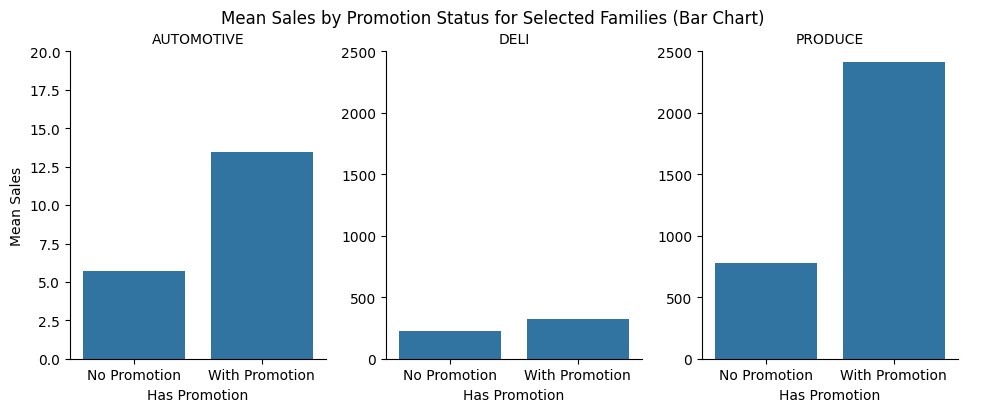

In [ ]:
# Define the families to include
selected_families = ['PRODUCE', 'DELI', 'AUTOMOTIVE']

# Filter the dataframe to include only rows with these families
filtered_train_merged_families = train_merged[train_merged['family'].isin(selected_families)].copy()

# Ensure 'has_promotion' column exists
if 'has_promotion' not in filtered_train_merged_families.columns:
     filtered_train_merged_families['has_promotion'] = filtered_train_merged_families['onpromotion'] > 0

# Calculate mean sales by family and promotion status
mean_sales_by_family_promotion = filtered_train_merged_families.groupby(['family', 'has_promotion'])['sales'].mean().reset_index()

# Create bar plots faceted by family with independent y-axes
g = sns.catplot(data=mean_sales_by_family_promotion, x='has_promotion', y='sales', col='family', kind='bar', col_wrap=3, height=4, aspect=0.8, sharey=False)
g.fig.suptitle('Mean Sales by Promotion Status for Selected Families (Bar Chart)', y=1.02)
g.set_axis_labels("Has Promotion", "Mean Sales")
g.set_xticklabels(['No Promotion', 'With Promotion'])
g.set_titles("{col_name}")

# Adjust y-axis limits for specific subplots
for ax in g.axes.flat:
    family_name = ax.get_title()
    print(f"Processing family: {family_name}") # Added for debugging
    if 'AUTOMOTIVE' in family_name:
        ax.set_ylim(0, 20) # Set a smaller y-limit for low-sales families
        print(f"Setting y-limit for {family_name} to (0, 20)") # Added for debugging
    elif 'PRODUCE' in family_name or 'DELI' in family_name:
         ax.set_ylim(0, 2500) # Set a larger y-limit for PRODUCE and DELI
         print(f"Setting y-limit for {family_name} to (0, 2500)") # Added for debugging


plt.show()

#Bước 2: Tiền xử lí dữ liệu

##2.1 Fill và trực quan dữ liệu giá dầu

###2.1.1 Fill giá dầu có giá trị NaN

In [ ]:
# Điền giá trị thiếu trong dcoilwtico cho train_merged bằng ffill trước (sử dụng các giá trị trước đó)
train_merged['dcoilwtico'] = train_merged['dcoilwtico'].fillna(method='ffill')

# Sau đó, điền bất kỳ giá trị NaN còn lại ở đầu train_merged bằng bfill
train_merged['dcoilwtico'] = train_merged['dcoilwtico'].fillna(method='bfill')

# Hiển thị thông tin để kiểm tra số lượng giá trị không bị thiếu cho train_merged
print("Thông tin train_merged sau khi điền giá trị thiếu cho 'dcoilwtico':")
train_merged.info(show_counts=True)

# Tìm ngày cuối cùng trong train_merged
last_train_date = train_merged['date'].max()

# Hiển thị giá dầu vào ngày cuối cùng của tập train
print(f"\nGiá dầu vào ngày cuối cùng của tập train ({last_train_date.date()}):")
display(train_merged[train_merged['date'] == last_train_date]['dcoilwtico'].iloc[0])

/tmp/ipython-input-85046730.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_merged['dcoilwtico'] = train_merged['dcoilwtico'].fillna(method='ffill')
/tmp/ipython-input-85046730.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_merged['dcoilwtico'] = train_merged['dcoilwtico'].fillna(method='bfill')


Thông tin train_merged sau khi điền giá trị thiếu cho 'dcoilwtico':
<class 'pandas.core.frame.DataFrame'>
Index: 2596374 entries, 0 to 2657489
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   id             2596374 non-null  int64         
 1   date           2596374 non-null  datetime64[ns]
 2   store_nbr      2596374 non-null  int64         
 3   family         2596374 non-null  object        
 4   sales          2596374 non-null  float64       
 5   onpromotion    2596374 non-null  int64         
 6   city           2596374 non-null  object        
 7   state          2596374 non-null  object        
 8   type           2596374 non-null  object        
 9   cluster        2596374 non-null  int64         
 10  dcoilwtico     2596374 non-null  float64       
 11  type_hd        2596374 non-null  object        
 12  locale         2596374 non-null  object        
 13  locale_name    2596374 n

np.float64(53.75)

In [ ]:
display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup,has_sales,month,has_promotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,0,0,0,1,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,0,0,0,1,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,0,0,0,1,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,0,0,0,1,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,0,0,0,1,False


In [ ]:
# Điền giá trị thiếu trong dcoilwtico cho val_merged bằng ffill trước (sử dụng các giá trị trước đó)
val_merged['dcoilwtico'] = val_merged['dcoilwtico'].fillna(method='ffill')

# Sau đó, điền bất kỳ giá trị NaN còn lại ở đầu val_merged bằng bfill
val_merged['dcoilwtico'] = val_merged['dcoilwtico'].fillna(method='bfill')

# Hiển thị thông tin để kiểm tra số lượng giá trị không bị thiếu cho val_merged
print("Thông tin val_merged sau khi điền giá trị thiếu cho 'dcoilwtico':")
val_merged.info(show_counts=True)

# Tìm ngày đầu tiên trong val_merged
first_val_date = val_merged['date'].min()

# Hiển thị giá dầu vào ngày đầu tiên của tập val
print(f"\nGiá dầu vào ngày đầu tiên của tập val ({first_val_date.date()}):")
display(val_merged[val_merged['date'] == first_val_date]['dcoilwtico'].iloc[0])

Thông tin val_merged sau khi điền giá trị thiếu cho 'dcoilwtico':
<class 'pandas.core.frame.DataFrame'>
Index: 404514 entries, 0 to 411641
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             404514 non-null  int64         
 1   date           404514 non-null  datetime64[ns]
 2   store_nbr      404514 non-null  int64         
 3   family         404514 non-null  object        
 4   sales          404514 non-null  float64       
 5   onpromotion    404514 non-null  int64         
 6   city           404514 non-null  object        
 7   state          404514 non-null  object        
 8   type           404514 non-null  object        
 9   cluster        404514 non-null  int64         
 10  dcoilwtico     404514 non-null  float64       
 11  type_hd        404514 non-null  object        
 12  locale         404514 non-null  object        
 13  locale_name    404514 non-null  object     

/tmp/ipython-input-475491600.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_merged['dcoilwtico'] = val_merged['dcoilwtico'].fillna(method='ffill')
/tmp/ipython-input-475491600.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_merged['dcoilwtico'] = val_merged['dcoilwtico'].fillna(method='bfill')


np.float64(52.36)

In [ ]:
display(val_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup,has_sales
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,52.36,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,52.36,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,52.36,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,52.36,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,52.36,No Holiday,No Holiday,No Holiday,No Holiday,0,0,0


### 2.1.2 Trực quan hóa dữ liệu doanh số và giá dầu

In [ ]:
daily_sales = train_merged.groupby('date')['sales'].sum().reset_index()
display(daily_sales.head())

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


##### Chuẩn bị dữ liệu giá dầu



In [ ]:
daily_oil_price = train_merged[['date', 'dcoilwtico']].drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)
display(daily_oil_price.head())

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


##### Hợp nhất dữ liệu theo doanh số và giá dầu




In [ ]:
merged_data = pd.merge(daily_sales, daily_oil_price, on='date', how='left')
print("Info of the merged dataframe:")
merged_data.info()
print("\nHead of the merged dataframe:")
display(merged_data.head())

Info of the merged dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1457 non-null   datetime64[ns]
 1   sales       1457 non-null   float64       
 2   dcoilwtico  1457 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 34.3 KB

Head of the merged dataframe:


,date,sales,dcoilwtico
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,93.12


##### Trực quan hóa: Vẽ biểu đồ đường hiển thị doanh số hàng ngày và giá dầu theo thời gian trên cùng một biểu đồ.


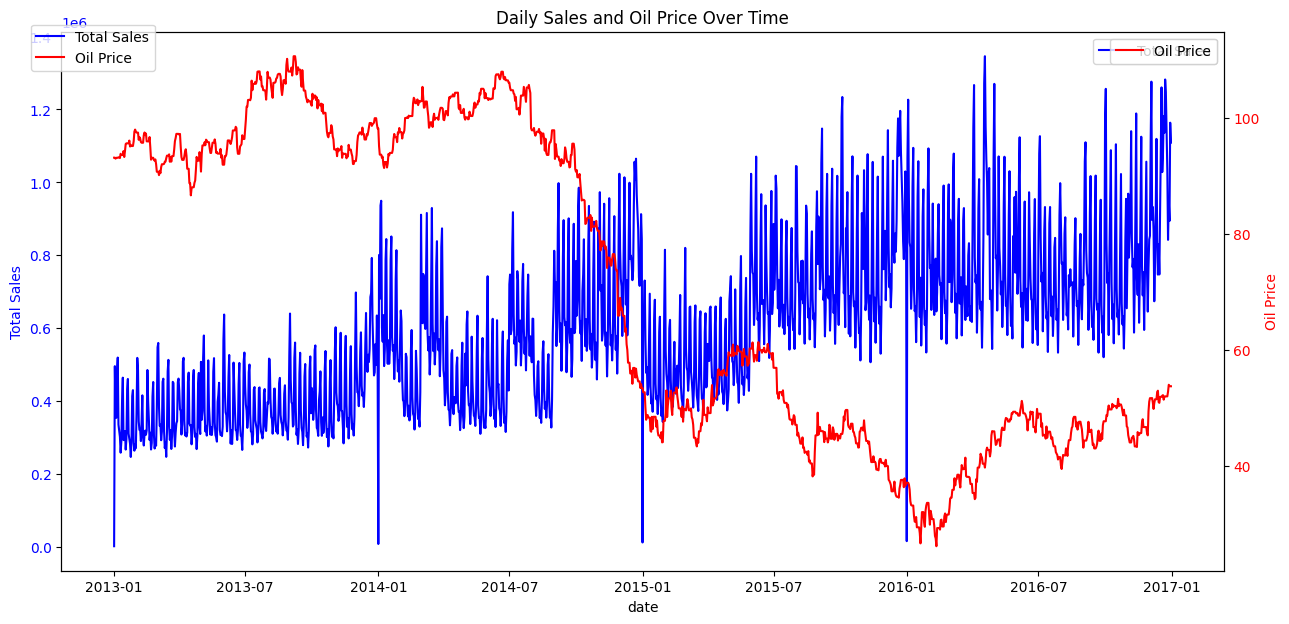

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot daily sales
sns.lineplot(data=merged_data, x='date', y='sales', ax=ax1, color='blue', label='Total Sales')
ax1.set_ylabel('Total Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for oil price
ax2 = ax1.twinx()
sns.lineplot(data=merged_data, x='date', y='dcoilwtico', ax=ax2, color='red', label='Oil Price')
ax2.set_ylabel('Oil Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and legends
plt.title('Daily Sales and Oil Price Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()

##2.2 One-hot encode cho biến ngày lễ/sự kiện dựa trên phạm vi và trực quan hóa



###2.2.1 One hot encode cho biến ngày lễ/ sự kiện


In [ ]:
# Tạo các cột mới để đánh dấu loại ngày
train_merged['is_local_event'] = np.where((train_merged['locale'] == 'Local') & (train_merged['type_hd'] != 'No Holiday'), 1, 0)
train_merged['is_regional_event'] = np.where((train_merged['locale'] == 'Regional') & (train_merged['type_hd'] != 'No Holiday'), 1, 0)
train_merged['is_national_event'] = np.where((train_merged['locale'] == 'National') & (train_merged['type_hd'] != 'No Holiday'), 1, 0)
train_merged['is_bonus_event'] = np.where((train_merged['locale'] == 'Bonus Event') & (train_merged['type_hd'] != 'No Holiday'), 1, 0)
train_merged['is_normal_day'] = np.where(train_merged['type_hd'] == 'No Holiday', 1, 0)

# Display the head of the dataframe with the new columns
display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_earthquake,world_cup,has_sales,month,has_promotion,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0


In [ ]:
# Tạo các cột mới để đánh dấu loại ngày cho val_merged
val_merged['is_local_event'] = np.where((val_merged['locale'] == 'Local') & (val_merged['type_hd'] != 'No Holiday'), 1, 0)
val_merged['is_regional_event'] = np.where((val_merged['locale'] == 'Regional') & (val_merged['type_hd'] != 'No Holiday'), 1, 0)
val_merged['is_national_event'] = np.where((val_merged['locale'] == 'National') & (val_merged['type_hd'] != 'No Holiday'), 1, 0)
val_merged['is_bonus_event'] = np.where((val_merged['locale'] == 'Bonus Event') & (val_merged['type_hd'] != 'No Holiday'), 1, 0)
val_merged['is_normal_day'] = np.where(val_merged['type_hd'] == 'No Holiday', 1, 0)

# Hiển thị phần đầu của dataframe val_merged với các cột mới
print("Val Merged Head with new holiday event columns:")
display(val_merged.head())

Val Merged Head with new holiday event columns:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,locale_name,description,is_earthquake,world_cup,has_sales,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,No Holiday,No Holiday,0,0,0,0,0,0,0,1
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,No Holiday,No Holiday,0,0,0,0,0,0,0,1
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,No Holiday,No Holiday,0,0,0,0,0,0,0,1
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,No Holiday,No Holiday,0,0,0,0,0,0,0,1
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,No Holiday,No Holiday,0,0,0,0,0,0,0,1


###2.2.2 So sánh doanh số ngày lễ/sự kiện và ngày thường theo phạm vi




In [ ]:
# Tính doanh số trung bình cho các ngày có ngày lễ/sự kiện theo phạm vi
national_event_sales = train_merged.groupby('is_national_event')['sales'].mean()
regional_event_sales = train_merged.groupby('is_regional_event')['sales'].mean()
local_event_sales = train_merged.groupby('is_local_event')['sales'].mean()

print("Mean sales for national events:")
display(national_event_sales)

print("\nMean sales for regional events:")
display(regional_event_sales)

print("\nMean sales for local events:")
display(local_event_sales)

Mean sales for national events:


,sales
is_national_event,
0,331.936311
1,409.850503



Mean sales for regional events:


,sales
is_regional_event,
0,338.753319
1,223.797186



Mean sales for local events:


,sales
is_local_event,
0,338.291799
1,445.068691


###2.2.3 Trực quan hóa tác động của ngày lễ/sự kiện theo phạm vi



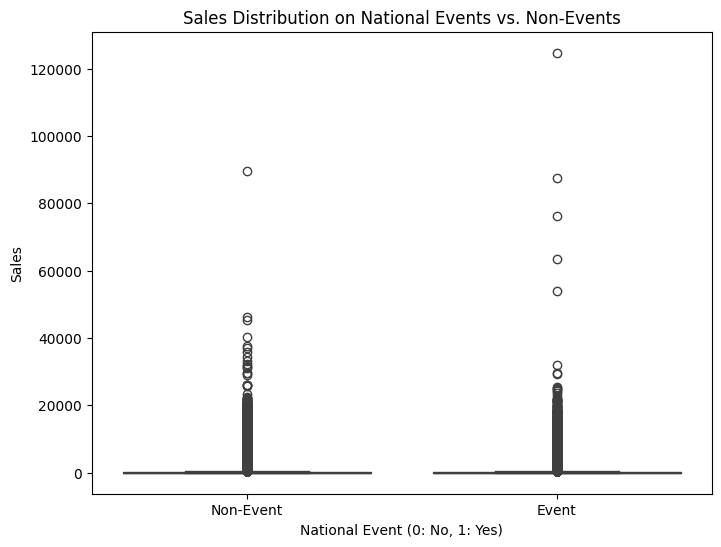

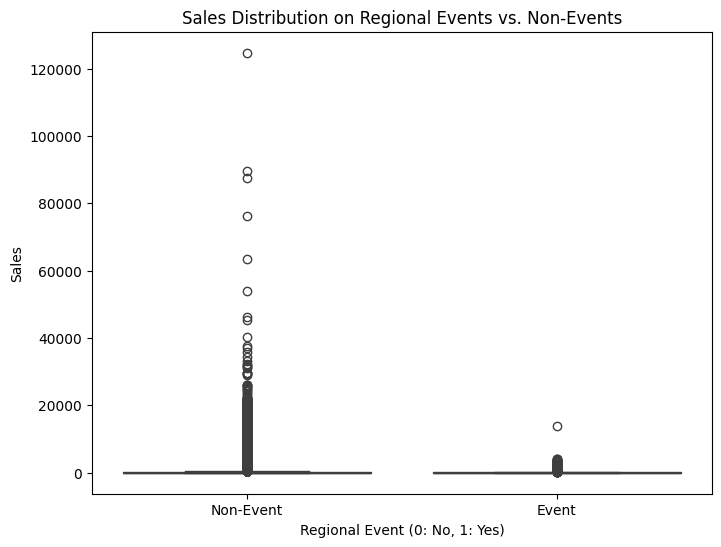

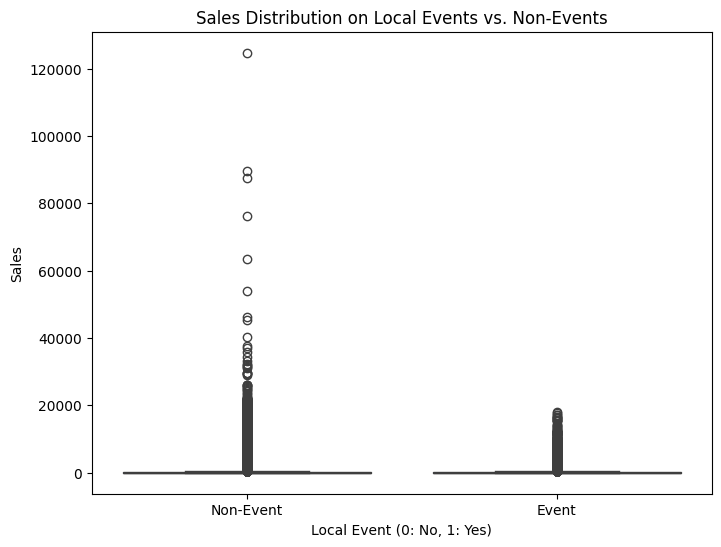

In [ ]:
# Boxplot for National Events
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='is_national_event', y='sales')
plt.title('Sales Distribution on National Events vs. Non-Events')
plt.xlabel('National Event (0: No, 1: Yes)')
plt.ylabel('Sales')
plt.xticks([0, 1], ['Non-Event', 'Event'])
plt.show()

# Boxplot for Regional Events
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='is_regional_event', y='sales')
plt.title('Sales Distribution on Regional Events vs. Non-Events')
plt.xlabel('Regional Event (0: No, 1: Yes)')
plt.ylabel('Sales')
plt.xticks([0, 1], ['Non-Event', 'Event'])
plt.show()

# Boxplot for Local Events
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='is_local_event', y='sales')
plt.title('Sales Distribution on Local Events vs. Non-Events')
plt.xlabel('Local Event (0: No, 1: Yes)')
plt.ylabel('Sales')
plt.xticks([0, 1], ['Non-Event', 'Event'])
plt.show()

In [ ]:
display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_earthquake,world_cup,has_sales,month,has_promotion,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,0,1,False,0,0,1,0,0


In [ ]:
print("Số lượng giá trị distinct trong cột 'city':")
display(train_merged['city'].nunique())

print("\nSố lượng giá trị distinct trong cột 'state':")
display(train_merged['state'].nunique())

Số lượng giá trị distinct trong cột 'city':


22


Số lượng giá trị distinct trong cột 'state':


16

##2.3 Phân cụm các thành phố thành 4 nhóm A, B, C, D dựa trên mức đóng góp doanh số và giao dịch

###2.3.1 Tính doanh số trung bình theo thành phố




In [ ]:
city_average_sales = train_merged.groupby('city')['sales'].mean().reset_index()
display(city_average_sales.head())

,city,sales
0,Ambato,348.196552
1,Babahoyo,306.315585
2,Cayambe,492.935452
3,Cuenca,271.612801
4,Daule,326.136993


###2.3.2 Tính giao dịch trung bình theo thành phố



In [ ]:
trans_merged_stores = pd.merge(trans, stores, on='store_nbr', how='left')
display(trans_merged_stores.tail())
# Chuyển cột date sang dạng datetime (nếu chưa có)
trans_merged_stores['date'] = pd.to_datetime(trans_merged_stores['date'])

# Lọc dữ liệu đến ngày 2016-12-31
trans_merged_stores_filtered = trans_merged_stores[trans_merged_stores['date'] <= '2016-12-31']

city_average_transactions = trans_merged_stores_filtered.groupby('city')['transactions'].mean().reset_index()
# Hiển thị vài dòng đầu để kiểm tra
display(trans_merged_stores_filtered.head())
display(trans_merged_stores_filtered.tail())
display(city_average_transactions.head())


,date,store_nbr,transactions,city,state,type,cluster
83483,2017-08-15,50,2804,Ambato,Tungurahua,A,14
83484,2017-08-15,51,1573,Guayaquil,Guayas,A,17
83485,2017-08-15,52,2255,Manta,Manabi,A,11
83486,2017-08-15,53,932,Manta,Manabi,D,13
83487,2017-08-15,54,802,El Carmen,Manabi,C,3


,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-01,25,770,Salinas,Santa Elena,D,1
1,2013-01-02,1,2111,Quito,Pichincha,D,13
2,2013-01-02,2,2358,Quito,Pichincha,D,13
3,2013-01-02,3,3487,Quito,Pichincha,D,8
4,2013-01-02,4,1922,Quito,Pichincha,D,9


,date,store_nbr,transactions,city,state,type,cluster
71386,2016-12-31,49,4051,Quito,Pichincha,A,11
71387,2016-12-31,50,3388,Ambato,Tungurahua,A,14
71388,2016-12-31,51,2742,Guayaquil,Guayas,A,17
71389,2016-12-31,53,2718,Manta,Manabi,D,13
71390,2016-12-31,54,1647,El Carmen,Manabi,C,3


,city,transactions
0,Ambato,1845.988629
1,Babahoyo,1372.966942
2,Cayambe,2377.273793
3,Cuenca,1401.118599
4,Daule,1456.456926


In [ ]:
display(trans_merged_stores_filtered.columns)

Index(['date', 'store_nbr', 'transactions', 'city', 'state', 'type',
       'cluster'],
      dtype='object')

###2.3.3 Hợp nhất dữ liệu để phân cụm




In [ ]:
city_data = pd.merge(city_average_sales, city_average_transactions, on='city', how='left')
display(city_data.head())

,city,sales,transactions
0,Ambato,348.196552,1845.988629
1,Babahoyo,306.315585,1372.966942
2,Cayambe,492.935452,2377.273793
3,Cuenca,271.612801,1401.118599
4,Daule,326.136993,1456.456926


In [ ]:
X = city_data[['sales', 'transactions']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
city_data['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

display(city_data.head())

,city,sales,transactions,kmeans_cluster
0,Ambato,348.196552,1845.988629,2
1,Babahoyo,306.315585,1372.966942,2
2,Cayambe,492.935452,2377.273793,1
3,Cuenca,271.612801,1401.118599,0
4,Daule,326.136993,1456.456926,2


In [ ]:
city = city_data[['city', 'kmeans_cluster']]
display(city)

,city,kmeans_cluster
0,Ambato,2
1,Babahoyo,2
2,Cayambe,1
3,Cuenca,0
4,Daule,2
5,El Carmen,3
6,Esmeraldas,0
7,Guaranda,0
8,Guayaquil,0
9,Ibarra,0


###2.3.4 Đưa kmean_cluster vào train/val

In [ ]:
# Hợp nhất dataframe city (chứa nhãn cụm) với train_merged
train_merged = pd.merge(train_merged, city[['city', 'kmeans_cluster']], on='city', how='left')

# Hợp nhất dataframe city (chứa nhãn cụm) với val_merged
val_merged = pd.merge(val_merged, city[['city', 'kmeans_cluster']], on='city', how='left')

# Hiển thị phần đầu của các dataframe để kiểm tra cột mới
print("Train Merged Head với K-Means Cluster:")
display(train_merged.head())

print("\nVal Merged Head với K-Means Cluster:")
display(val_merged.head())

Train Merged Head với K-Means Cluster:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,world_cup,has_sales,month,has_promotion,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,1,False,0,0,1,0,0,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,1,False,0,0,1,0,0,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,1,False,0,0,1,0,0,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,1,False,0,0,1,0,0,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,1,False,0,0,1,0,0,1



Val Merged Head với K-Means Cluster:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,description,is_earthquake,world_cup,has_sales,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,No Holiday,0,0,0,0,0,0,0,1,1
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,No Holiday,0,0,0,0,0,0,0,1,1
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,No Holiday,0,0,0,0,0,0,0,1,1
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,No Holiday,0,0,0,0,0,0,0,1,1
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,No Holiday,0,0,0,0,0,0,0,1,1


##2.4 Chuẩn hóa cột dcoilwtico:Áp dụng Min-Max Scaling

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape the column and apply scaling
train_merged['dcoilwtico_scaled'] = scaler.fit_transform(train_merged[['dcoilwtico']])

# Display the head of the dataframe with the new scaled column
display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,has_sales,month,has_promotion,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,1,False,0,0,1,0,0,1,0.792965
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,1,False,0,0,1,0,0,1,0.792965
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,1,False,0,0,1,0,0,1,0.792965
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,1,False,0,0,1,0,0,1,0.792965
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,1,False,0,0,1,0,0,1,0.792965


In [ ]:
# Áp dụng cùng scaler đã huấn luyện trên tập train để chuẩn hóa dcoilwtico trên val_merged
val_merged['dcoilwtico_scaled'] = scaler.transform(val_merged[['dcoilwtico']])

# Hiển thị phần đầu của dataframe val_merged với cột đã chuẩn hóa mới
print("Val Merged Head with scaled dcoilwtico:")
display(val_merged.head())

Val Merged Head with scaled dcoilwtico:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_earthquake,world_cup,has_sales,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,1,1,0.309961
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,1,1,0.309961
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,1,1,0.309961
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,1,1,0.309961
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,1,1,0.309961


##2.5 Áp dụng Label Encoding cho store_nbr và family


In [ ]:
# Initialize LabelEncoders
store_le = LabelEncoder()
family_le = LabelEncoder()

# Apply Label Encoding to the columns
train_merged['store_nbr_encoded'] = store_le.fit_transform(train_merged['store_nbr'])
train_merged['family_encoded'] = family_le.fit_transform(train_merged['family'])

# Display the head of the dataframe with the new encoded columns
display(train_merged.head())

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,has_promotion,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,False,0,0,1,0,0,1,0.792965,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,False,0,0,1,0,0,1,0.792965,0,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,False,0,0,1,0,0,1,0.792965,0,2
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,False,0,0,1,0,0,1,0.792965,0,3
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,False,0,0,1,0,0,1,0.792965,0,4


In [ ]:
# Áp dụng Label Encoding cho các cột 'store_nbr' và 'family' trên val_merged
# Sử dụng cùng các LabelEncoder đã được huấn luyện trên train_merged
val_merged['store_nbr_encoded'] = store_le.transform(val_merged['store_nbr'])
val_merged['family_encoded'] = family_le.transform(val_merged['family'])

# Hiển thị phần đầu của dataframe val_merged với các cột đã mã hóa mới
print("Val Merged Head với các cột 'store_nbr_encoded' và 'family_encoded':")
display(val_merged.head())

Val Merged Head với các cột 'store_nbr_encoded' và 'family_encoded':


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,has_sales,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,1,1,0.309961,0,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,1,1,0.309961,0,1
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,1,1,0.309961,0,2
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,1,1,0.309961,0,3
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,1,1,0.309961,0,4


##2.6 Trích xuất đặc trưng thời gian từ cột date



In [ ]:
# Trích xuất các đặc trưng dựa trên thời gian cho train_merged
train_merged['month'] = train_merged['date'].dt.month          # Trích xuất tháng
train_merged['is_weekend'] = (train_merged['date'].dt.dayofweek >= 5).astype(int) # Tạo biến nhị phân: 1 nếu là cuối tuần (Thứ 7 hoặc Chủ Nhật), 0 nếu là ngày thường

# Hiển thị phần đầu của cả hai dataframe với các đặc trưng mới
print("Train Merged Head với các đặc trưng thời gian đã chọn:")
display(train_merged.head())



Train Merged Head với các đặc trưng thời gian đã chọn:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,1,0,0,1,0.792965,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,1,0,0,1,0.792965,0,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,1,0,0,1,0.792965,0,2,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,1,0,0,1,0.792965,0,3,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,1,0,0,1,0.792965,0,4,0


In [ ]:
# Trích xuất các đặc trưng dựa trên thời gian cho val_merged (đảm bảo tính nhất quán)
val_merged['month'] = val_merged['date'].dt.month          # Trích xuất tháng
val_merged['dayofyear'] = val_merged['date'].dt.dayofyear    # Trích xuất ngày trong năm
val_merged['weekofyear'] = val_merged['date'].dt.isocalendar().week.astype(int) # Trích xuất tuần trong năm (chuyển sang kiểu int)
val_merged['is_weekend'] = (val_merged['date'].dt.dayofweek >= 5).astype(int) # Tạo biến nhị phân: 1 nếu là cuối tuần (Thứ 7 hoặc Chủ Nhật), 0 nếu là ngày thường

print("\nVal Merged Head với các đặc trưng thời gian đã chọn:")
display(val_merged.head())


Val Merged Head với các đặc trưng thời gian đã chọn:


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded,month,dayofyear,weekofyear,is_weekend
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,1,1,0.309961,0,0,1,1,52,1
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,1,1,0.309961,0,1,1,1,52,1
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,1,1,0.309961,0,2,1,1,52,1
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,1,1,0.309961,0,3,1,1,52,1
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,1,1,0.309961,0,4,1,1,52,1


##2.7 One-Hot Encoding cho type, type_hd, month và cluster (với giá trị 1/0)



In [ ]:
# Áp dụng One-Hot Encoding cho cột 'month' trong train_merged
# Loại bỏ cột gốc sau khi mã hóa (drop_first=True)
train_merged_dummies = pd.get_dummies(train_merged, columns=['month'], drop_first=True)

# Chuyển đổi các cột biến giả mới sang kiểu số nguyên (1/0)
for col in train_merged_dummies.columns:
    # Kiểm tra xem đây có phải là cột biến giả mới hoặc cột gốc đã được xử lý không
    if col not in train_merged.columns or col in ['month']:
         # Chỉ chuyển đổi nếu cột là kiểu boolean (biến giả mới)
        if train_merged_dummies[col].dtype == 'bool':
             train_merged_dummies[col] = train_merged_dummies[col].astype(int)


# Cập nhật train_merged với các cột đã được mã hóa
train_merged = train_merged_dummies.copy()

# Hiển thị phần đầu của dataframe với các cột đã được mã hóa One-Hot mới
print("Train Merged Head sau khi One-Hot Encoding 'month':")
display(train_merged.head())

Train Merged Head sau khi One-Hot Encoding 'month':


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Áp dụng One-Hot Encoding cho các cột 'month' trong val_merged
# Loại bỏ các cột gốc sau khi mã hóa (drop_first=True)
val_merged_dummies = pd.get_dummies(val_merged, columns=['month'], drop_first=True)

# Chuyển đổi các cột biến giả mới sang kiểu số nguyên (1/0)
for col in val_merged_dummies.columns:
    # Kiểm tra xem đây có phải là cột biến giả mới hoặc cột gốc đã được xử lý không
    if col not in val_merged.columns or col in ['month']:
        # Chỉ chuyển đổi nếu cột là kiểu boolean (biến giả mới)
        if val_merged_dummies[col].dtype == 'bool':
            val_merged_dummies[col] = val_merged_dummies[col].astype(int)

# Cập nhật val_merged với các cột đã được mã hóa
val_merged = val_merged_dummies.copy()

# Hiển thị phần đầu của dataframe với các cột đã được mã hóa One-Hot mới
print("Val Merged Head sau khi One-Hot Encoding 'month':")
display(val_merged.head())

Val Merged Head sau khi One-Hot Encoding 'month':


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,dayofyear,weekofyear,is_weekend,month_2,month_3,month_4,month_5,month_6,month_7,month_8
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,52,1,0,0,0,0,0,0,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,52,1,0,0,0,0,0,0,0
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,52,1,0,0,0,0,0,0,0
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,52,1,0,0,0,0,0,0,0
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,52,1,0,0,0,0,0,0,0


In [ ]:
# Áp dụng One-Hot Encoding cho cột 'type' và 'type_hd' trong train_merged
train_merged_dummies = pd.get_dummies(train_merged, columns=['type', 'type_hd'], drop_first=True)

# Chuyển đổi các cột biến giả mới sang kiểu số nguyên (1/0)
for col in train_merged_dummies.columns:
    # Kiểm tra xem đây có phải là cột biến giả mới hoặc cột gốc đã được xử lý không
    if col not in train_merged.columns or col in ['type', 'type_hd']:
         # Chỉ chuyển đổi nếu cột là kiểu số hoặc boolean
        if train_merged_dummies[col].dtype in ['bool', 'float64', 'int64']:
             train_merged_dummies[col] = train_merged_dummies[col].astype(int)

# Cập nhật train_merged với các cột đã được mã hóa
train_merged = train_merged_dummies.copy()

# Hiển thị phần đầu của dataframe với các cột đã được mã hóa One-Hot mới
print("Train Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):")
display(train_merged.head())

Train Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_C,type_D,type_E,type_hd_Bonus Event,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,0,1,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,0,1,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,0,1,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,0,1,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
# Áp dụng One-Hot Encoding cho cột 'type' và 'type_hd' trong val_merged
val_merged_dummies = pd.get_dummies(val_merged, columns=['type', 'type_hd'], drop_first=True)

# Chuyển đổi các cột biến giả mới sang kiểu số nguyên (1/0)
for col in val_merged_dummies.columns:
    # Kiểm tra xem đây có phải là cột biến giả mới hoặc cột gốc đã được xử lý không
    if col not in val_merged.columns or col in ['type', 'type_hd']:
        # Chỉ chuyển đổi nếu cột là kiểu số hoặc boolean
        if val_merged_dummies[col].dtype in ['bool', 'float64', 'int64']:
            val_merged_dummies[col] = val_merged_dummies[col].astype(int)

# Cập nhật val_merged với các cột đã được mã hóa
val_merged = val_merged_dummies.copy()

# Xác định các cột bị thiếu trong val_merged so với train_merged
missing_cols_in_val = set(train_merged.columns) - set(val_merged.columns)

# Thêm các cột bị thiếu vào val_merged và điền giá trị 0
for col in missing_cols_in_val:
     # Only add if the column is a dummy variable for 'type_hd' or 'type' and not 'sales'
     if ('type_hd_' in col or 'type_' in col) and col != 'sales':
         val_merged[col] = 0


print("\nVal Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):")
display(val_merged.head())


Val Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_C,type_D,type_E,type_hd_Bonus Event,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Bridge,type_hd_Work Day
0,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,52.36,...,0,1,0,0,0,0,1,0,0,0
1,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,52.36,...,0,1,0,0,0,0,1,0,0,0
2,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,52.36,...,0,1,0,0,0,0,1,0,0,0
3,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,52.36,...,0,1,0,0,0,0,1,0,0,0
4,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,52.36,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
print("Các cột của val_merged:")
display(val_merged.columns)

Các cột của val_merged:


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'cluster', 'dcoilwtico', 'locale', 'locale_name',
       'description', 'is_earthquake', 'world_cup', 'has_sales',
       'is_local_event', 'is_regional_event', 'is_national_event',
       'is_bonus_event', 'is_normal_day', 'kmeans_cluster',
       'dcoilwtico_scaled', 'store_nbr_encoded', 'family_encoded', 'dayofyear',
       'weekofyear', 'is_weekend', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'type_B', 'type_C', 'type_D', 'type_E',
       'type_hd_Bonus Event', 'type_hd_Event', 'type_hd_Holiday',
       'type_hd_No Holiday', 'type_hd_Transfer', 'type_hd_Bridge',
       'type_hd_Work Day'],
      dtype='object')

##2.8 Tạo biến Sales Lag



In [ ]:
# Nối (concat) train_merged và val_merged theo chiều dọc
all_data_for_lags = pd.concat([train_merged, val_merged], ignore_index=True)

# Sắp xếp dữ liệu gộp theo store_nbr_encoded, family_encoded và date
# Việc sắp xếp này đảm bảo rằng các giá trị lag được tính toán đúng thứ tự thời gian
all_data_for_lags = all_data_for_lags.sort_values(by=['store_nbr_encoded', 'family_encoded', 'date'])

# Tính toán các đặc trưng lag trên dữ liệu gộp, nhóm theo store_nbr_encoded và family_encoded
all_data_for_lags['sales_lag_7'] = all_data_for_lags.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(7)
all_data_for_lags['sales_lag_30'] = all_data_for_lags.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(30)
all_data_for_lags['sales_lag_quarter'] = all_data_for_lags.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(90)


# Tách lại thành train_merged và val_merged dựa trên ngày chia ban đầu
train_merged = all_data_for_lags[all_data_for_lags['date'] <= last_train_date].copy()
val_merged = all_data_for_lags[all_data_for_lags['date'] > last_train_date].copy()

# Sắp xếp lại các dataframe theo id gốc để khôi phục thứ tự ban đầu
# Lưu ý: Cột 'id' cần tồn tại trong các dataframes để sắp xếp
if 'id' in train_merged.columns:
    train_merged = train_merged.sort_values(by='id')
if 'id' in val_merged.columns:
    val_merged = val_merged.sort_values(by='id')

# Hiển thị phần đầu của các dataframe mới với các đặc trưng lag
print("Train Merged Head sau khi tạo lag:")
display(train_merged.head())

print("\nVal Merged Head sau khi tạo lag:")
display(val_merged.head())

# Kiểm tra các giá trị NaN ở đầu val_merged và test_merged
print("\nChecking for NaNs in sales_lag_7 in the first few rows of val_merged:")
display(val_merged.head(10)[['date', 'store_nbr_encoded', 'family_encoded', 'sales_lag_7']])



Train Merged Head sau khi tạo lag:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN



Val Merged Head sau khi tạo lag:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,6.0,3.0,2.0
2596375,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,0.0,0.0,0.0
2596376,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,2.0,6.0,7.0
2596377,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,2576.0,2647.0,1277.0
2596378,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,8.0,1.0,0.0



Checking for NaNs in sales_lag_7 in the first few rows of val_merged:


,date,store_nbr_encoded,family_encoded,sales_lag_7
2596374,2017-01-01,0,0,6.000
2596375,2017-01-01,0,1,0.000
2596376,2017-01-01,0,2,2.000
2596377,2017-01-01,0,3,2576.000
2596378,2017-01-01,0,4,8.000
2596379,2017-01-01,0,5,353.597
2596380,2017-01-01,0,6,13.000
2596381,2017-01-01,0,7,620.000
2596382,2017-01-01,0,8,934.000
2596383,2017-01-01,0,9,133.111


In [ ]:
# Lọc train_merged cho store_nbr = 4 và ngày 2016-12-25
data_2016_12_25_store_1 = train_merged[(train_merged['store_nbr'] == 4) & (train_merged['date'] == '2016-12-26')]

print("Hàng dữ liệu cho cửa hàng 4 vào ngày 25/12/2016:")
display(data_2016_12_25_store_1)

Hàng dữ liệu cho cửa hàng 4 vào ngày 25/12/2016:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
2586771,2586771,2016-12-26,4,AUTOMOTIVE,8.000,0,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,4.00000,1.000000,4.000
2586772,2586772,2016-12-26,4,BABY CARE,2.000,0,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,0.00000,0.000000,0.000
2586773,2586773,2016-12-26,4,BEAUTY,13.000,1,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,12.00000,0.000000,1.000
2586774,2586774,2016-12-26,4,BEVERAGES,3275.000,61,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,4258.00000,2327.000000,2390.000
2586775,2586775,2016-12-26,4,BOOKS,0.000,0,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,1.00000,0.000000,0.000
2586776,2586776,2016-12-26,4,BREAD/BAKERY,408.339,2,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,565.56600,358.628000,483.249
2586777,2586777,2016-12-26,4,CELEBRATION,8.000,0,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,13.00000,7.000000,4.000
2586778,2586778,2016-12-26,4,CLEANING,1081.000,33,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,1357.00000,686.000000,749.000
2586779,2586779,2016-12-26,4,DAIRY,926.000,30,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,1378.00000,677.000000,775.000
2586780,2586780,2016-12-26,4,DELI,230.604,12,Quito,Pichincha,9,52.01,...,0,0,0,0,0,NaN,NaN,318.18900,205.853000,205.934


In [ ]:
# Lọc val_merged cho store_nbr = 4 và ngày 02/01/2017
data_store_4_2017_01_02_val = val_merged[(val_merged['store_nbr'] == 4) & (val_merged['date'] == '2017-01-02')]

print("Dữ liệu cho cửa hàng 4 vào ngày 02/01/2017 trên tập valid:")
display(data_store_4_2017_01_02_val)

Dữ liệu cho cửa hàng 4 vào ngày 02/01/2017 trên tập valid:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
2599245,2599245,2017-01-02,4,AUTOMOTIVE,9.000,0,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,8.000,1.000,3.000
2599246,2599246,2017-01-02,4,BABY CARE,1.000,0,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,2.000,0.000,0.000
2599247,2599247,2017-01-02,4,BEAUTY,17.000,1,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,13.000,4.000,3.000
2599248,2599248,2017-01-02,4,BEVERAGES,5566.000,45,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,3275.000,2688.000,3113.000
2599249,2599249,2017-01-02,4,BOOKS,1.000,0,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,0.000,3.000,0.000
2599250,2599250,2017-01-02,4,BREAD/BAKERY,768.075,3,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,408.339,407.861,495.546
2599251,2599251,2017-01-02,4,CELEBRATION,18.000,1,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,8.000,18.000,3.000
2599252,2599252,2017-01-02,4,CLEANING,1568.000,15,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,1081.000,905.000,1003.000
2599253,2599253,2017-01-02,4,DAIRY,1488.000,18,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,926.000,846.000,857.000
2599254,2599254,2017-01-02,4,DELI,403.257,8,Quito,Pichincha,9,52.36,...,0,0,0,1,0,2.0,1.0,230.604,228.376,195.749


##2.9 Chuẩn hóa cột sales và các biến lag



In [ ]:
# Chọn các cột cần biến đổi logarit
cols_to_log = ['sales', 'sales_lag_7', 'sales_lag_30', 'sales_lag_quarter']

# Áp dụng phép biến đổi logarit (log1p để xử lý giá trị 0)
# Lưu ý: Áp dụng trên thang đo gốc trước khi chuẩn hóa nếu có chuẩn hóa khác sau này
# Trong trường hợp này, chúng ta chỉ thay thế chuẩn hóa bằng logarit
train_merged[cols_to_log] = np.log1p(train_merged[cols_to_log])
val_merged[cols_to_log] = np.log1p(val_merged[cols_to_log])
# test_merged sẽ được xử lý sau khi tạo lag trên toàn bộ dữ liệu

# Hiển thị phần đầu của dataframe với các cột đã được biến đổi logarit
print("Train Merged Head với các đặc trưng sales và lag đã được biến đổi logarit:")
display(train_merged.head())

print("\nTrain Merged Tail với các đặc trưng sales và lag đã được biến đổi logarit:")
display(train_merged.tail())

print("\nVal Merged Head với các đặc trưng sales và lag đã được biến đổi logarit:")
display(val_merged.head())

print("\nVal Merged Tail với các đặc trưng sales và lag đã được biến đổi logarit:")
display(val_merged.tail())

Train Merged Head với các đặc trưng sales và lag đã được biến đổi logarit:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,93.14,...,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN



Train Merged Tail với các đặc trưng sales và lag đã được biến đổi logarit:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
2596369,2596369,2016-12-31,9,POULTRY,6.535028,1,Quito,Pichincha,6,53.75,...,0,0,0,0,0,NaN,NaN,6.591425,5.874341,6.670991
2596370,2596370,2016-12-31,9,PREPARED FOODS,4.619122,1,Quito,Pichincha,6,53.75,...,0,0,0,0,0,NaN,NaN,4.619605,4.744741,5.346950
2596371,2596371,2016-12-31,9,PRODUCE,8.036689,3,Quito,Pichincha,6,53.75,...,0,0,0,0,0,NaN,NaN,7.854025,7.176281,7.765358
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,1.098612,0,Quito,Pichincha,6,53.75,...,0,0,0,0,0,NaN,NaN,0.000000,0.000000,1.098612
2596373,2596373,2016-12-31,9,SEAFOOD,2.639057,2,Quito,Pichincha,6,53.75,...,0,0,0,0,0,NaN,NaN,2.708050,1.609438,3.465736



Val Merged Head với các đặc trưng sales và lag đã được biến đổi logarit:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,1.945910,1.386294,1.098612
2596375,2596375,2017-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,0.000000,0.000000,0.000000
2596376,2596376,2017-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,1.098612,1.945910,2.079442
2596377,2596377,2017-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,7.854381,7.881560,7.153052
2596378,2596378,2017-01-01,1,BOOKS,0.0,0,Quito,Pichincha,13,52.36,...,0,0,1,0,0,1.0,52.0,2.197225,0.693147,0.000000



Val Merged Tail với các đặc trưng sales và lag đã được biến đổi logarit:


,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,dayofyear,weekofyear,sales_lag_7,sales_lag_30,sales_lag_quarter
3000883,3000883,2017-08-15,9,POULTRY,6.084802,0,Quito,Pichincha,6,47.57,...,0,0,1,0,0,227.0,33.0,5.883690,6.349721,5.981025
3000884,3000884,2017-08-15,9,PREPARED FOODS,5.046987,1,Quito,Pichincha,6,47.57,...,0,0,1,0,0,227.0,33.0,4.735795,4.843872,4.481182
3000885,3000885,2017-08-15,9,PRODUCE,7.791824,148,Quito,Pichincha,6,47.57,...,0,0,1,0,0,227.0,33.0,7.740975,7.622158,7.239008
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,4.804021,8,Quito,Pichincha,6,47.57,...,0,0,1,0,0,227.0,33.0,5.141664,0.000000,1.386294
3000887,3000887,2017-08-15,9,SEAFOOD,2.833213,0,Quito,Pichincha,6,47.57,...,0,0,1,0,0,227.0,33.0,2.814090,2.961865,2.741163


##2.10 Kiểm tra sự khác biệt về cột và xóa các cột và hàng không cần thiết




### 2.10.1 Kiểm tra sự khác biệt về cột

In [ ]:
# Lấy các cột chỉ có trong train_merged
train_cols = set(train_merged.columns)
val_cols = set(val_merged.columns)

# Các cột bị thiếu trong val_merged so với train_merged
missing_in_val = list(train_cols - val_cols)
# Các cột bị thiếu trong train_merged so với val_merged (thường là rỗng)
missing_in_train = list(val_cols - train_cols)

print("Các cột có trong train_merged nhưng không có trong val_merged:")
display(missing_in_val)

print("\nCác cột có trong val_merged nhưng không có trong train_merged:")
display(missing_in_train)

Các cột có trong train_merged nhưng không có trong val_merged:


[]


Các cột có trong val_merged nhưng không có trong train_merged:


[]

###2.10.2 Xóa các cột không cần thiết

In [ ]:
# Danh sách các cột cần xóa
columns_to_drop = ['city', 'locale', 'locale_name', 'family', 'store_nbr', 'state', 'has_promotion', 'description']

# Xóa các cột khỏi train_merged
train_merged = train_merged.drop(columns=columns_to_drop, errors='ignore')
print("Các cột đã xóa khỏi train_merged.")

# Xóa các cột khỏi val_merged
val_merged = val_merged.drop(columns=columns_to_drop, errors='ignore')
print("Các cột đã xóa khỏi val_merged.")


# Hiển thị phần đầu của các DataFrame để xác nhận
print("\nTrain Merged Head sau khi xóa cột:")
display(train_merged.head())

print("\nVal Merged Head sau khi xóa cột:")
display(val_merged.head())

Các cột đã xóa khỏi train_merged.
Các cột đã xóa khỏi val_merged.

Train Merged Head sau khi xóa cột:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bonus Event,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter
0,0,2013-01-01,0.0,0,13,93.14,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN
1,1,2013-01-01,0.0,0,13,93.14,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN
2,2,2013-01-01,0.0,0,13,93.14,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN
3,3,2013-01-01,0.0,0,13,93.14,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN
4,4,2013-01-01,0.0,0,13,93.14,0,0,0,0,...,0,0,0,1,0,0,0,NaN,NaN,NaN



Val Merged Head sau khi xóa cột:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bonus Event,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter
2596374,2596374,2017-01-01,0.0,0,13,52.36,0,0,0,0,...,0,0,0,0,1,0,0,1.945910,1.386294,1.098612
2596375,2596375,2017-01-01,0.0,0,13,52.36,0,0,0,0,...,0,0,0,0,1,0,0,0.000000,0.000000,0.000000
2596376,2596376,2017-01-01,0.0,0,13,52.36,0,0,0,0,...,0,0,0,0,1,0,0,1.098612,1.945910,2.079442
2596377,2596377,2017-01-01,0.0,0,13,52.36,0,0,0,0,...,0,0,0,0,1,0,0,7.854381,7.881560,7.153052
2596378,2596378,2017-01-01,0.0,0,13,52.36,0,0,0,0,...,0,0,0,0,1,0,0,2.197225,0.693147,0.000000


In [ ]:
train_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2596374 entries, 0 to 2596373
Data columns (total 44 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   2596374 non-null  int64         
 1   date                 2596374 non-null  datetime64[ns]
 2   sales                2596374 non-null  float64       
 3   onpromotion          2596374 non-null  int64         
 4   cluster              2596374 non-null  int64         
 5   dcoilwtico           2596374 non-null  float64       
 6   is_earthquake        2596374 non-null  int64         
 7   world_cup            2596374 non-null  int64         
 8   has_sales            2596374 non-null  int64         
 9   is_local_event       2596374 non-null  int64         
 10  is_regional_event    2596374 non-null  int64         
 11  is_national_event    2596374 non-null  int64         
 12  is_bonus_event       2596374 non-null  int64         
 13  is

In [ ]:
val_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404514 entries, 2596374 to 3000887
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   404514 non-null  int64         
 1   date                 404514 non-null  datetime64[ns]
 2   sales                404514 non-null  float64       
 3   onpromotion          404514 non-null  int64         
 4   cluster              404514 non-null  int64         
 5   dcoilwtico           404514 non-null  float64       
 6   is_earthquake        404514 non-null  int64         
 7   world_cup            404514 non-null  int64         
 8   has_sales            404514 non-null  int64         
 9   is_local_event       404514 non-null  int64         
 10  is_regional_event    404514 non-null  int64         
 11  is_national_event    404514 non-null  int64         
 12  is_bonus_event       404514 non-null  int64         
 13  is_normal_da

In [ ]:
# Điền giá trị NaN trong các cột month_9, month_10, month_11, month_12 bằng 0 trong val_merged
months_to_fill = ['month_9', 'month_10', 'month_11', 'month_12']
for col in months_to_fill:
    if col in val_merged.columns:
        val_merged[col] = val_merged[col].fillna(0)

print("Đã điền giá trị 0 cho các cột month_9, month_10, month_11, month_12 trong val_merged.")

# Kiểm tra lại thông tin để xác nhận đã điền giá trị
val_merged.info(show_counts=True)

Đã điền giá trị 0 cho các cột month_9, month_10, month_11, month_12 trong val_merged.
<class 'pandas.core.frame.DataFrame'>
Index: 404514 entries, 2596374 to 3000887
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   404514 non-null  int64         
 1   date                 404514 non-null  datetime64[ns]
 2   sales                404514 non-null  float64       
 3   onpromotion          404514 non-null  int64         
 4   cluster              404514 non-null  int64         
 5   dcoilwtico           404514 non-null  float64       
 6   is_earthquake        404514 non-null  int64         
 7   world_cup            404514 non-null  int64         
 8   has_sales            404514 non-null  int64         
 9   is_local_event       404514 non-null  int64         
 10  is_regional_event    404514 non-null  int64         
 11  is_national_event    404514 non-null  int6

###2.10.3 Xóa các hàng có giá trị NaN

In [ ]:
# Xóa các hàng có giá trị NaN trong cột 'sales_lag_quarter' khỏi train_merged
train_merged = train_merged.dropna(subset=['sales_lag_quarter']).copy()

# Hiển thị thông tin dataframe để kiểm tra số lượng hàng sau khi xóa
print("Thông tin train_merged sau khi xóa các hàng có NaN trong 'sales_lag_quarter':")
train_merged.info(show_counts=True)

# Hiển thị phần đầu của dataframe để xác nhận
display(train_merged.head())

Thông tin train_merged sau khi xóa các hàng có NaN trong 'sales_lag_quarter':
<class 'pandas.core.frame.DataFrame'>
Index: 2435994 entries, 160380 to 2596373
Data columns (total 44 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   2435994 non-null  int64         
 1   date                 2435994 non-null  datetime64[ns]
 2   sales                2435994 non-null  float64       
 3   onpromotion          2435994 non-null  int64         
 4   cluster              2435994 non-null  int64         
 5   dcoilwtico           2435994 non-null  float64       
 6   is_earthquake        2435994 non-null  int64         
 7   world_cup            2435994 non-null  int64         
 8   has_sales            2435994 non-null  int64         
 9   is_local_event       2435994 non-null  int64         
 10  is_regional_event    2435994 non-null  int64         
 11  is_national_event    2435994 non-null

,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bonus Event,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter
160380,160380,2013-04-01,0.000000,0,13,97.1,0,0,0,0,...,0,0,0,0,1,0,0,1.609438,0.693147,0.0
160381,160381,2013-04-01,0.000000,0,13,97.1,0,0,0,0,...,0,0,0,0,1,0,0,0.000000,0.000000,0.0
160382,160382,2013-04-01,0.693147,0,13,97.1,0,0,1,0,...,0,0,0,0,1,0,0,1.098612,0.000000,0.0
160383,160383,2013-04-01,6.837333,0,13,97.1,0,0,1,0,...,0,0,0,0,1,0,0,6.753438,7.108244,0.0
160384,160384,2013-04-01,0.000000,0,13,97.1,0,0,0,0,...,0,0,0,0,1,0,0,0.000000,0.000000,0.0


#3 Mô hình 2 bước

##3.1 Chuẩn bị và huấn luyện mô hình phân loại

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Danh sách các cột cần loại bỏ khỏi tập đặc trưng cho mô hình phân loại
# Đây phải là các cột không dùng làm đặc trưng, bao gồm cả biến mục tiêu sales và has_sales
features_to_drop_classification = ['sales', 'date', 'id', 'has_sales', 'dcoilwtico'] # Loại bỏ dcoilwtico gốc, giữ lại scaled

# Chuẩn bị dữ liệu cho mô hình phân loại từ train_merged
X_train_classification = train_merged.drop(features_to_drop_classification, axis=1, errors='ignore')
y_train_classification = train_merged['has_sales']

# Chuẩn bị dữ liệu cho mô hình phân loại từ val_merged
X_val_classification = val_merged.drop(features_to_drop_classification, axis=1, errors='ignore')
y_val_classification = val_merged['has_sales']


print("Kích thước X_train_classification:", X_train_classification.shape)
print("Kích thước y_train_classification:", y_train_classification.shape)
print("Kích thước X_val_classification:", X_val_classification.shape)
print("Kích thước y_val_classification:", y_val_classification.shape)

print("\nCác cột của X_train_classification:")
display(X_train_classification.columns)
print("\nCác cột của X_val_classification:")
display(X_val_classification.columns)


# Huấn luyện mô hình phân loại (Ví dụ: XGBoost Classifier)
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_classification, y_train_classification)

print("\nĐã huấn luyện mô hình phân loại XGBoost.")

# Dự đoán trên tập validation cho mô hình phân loại
y_pred_val_classification = xgb_classifier.predict(X_val_classification)
y_pred_proba_val_classification = xgb_classifier.predict_proba(X_val_classification)[:, 1] # Xác suất của lớp dương (có sales)

# Đánh giá mô hình phân loại trên tập validation
accuracy = accuracy_score(y_val_classification, y_pred_val_classification)
precision = precision_score(y_val_classification, y_pred_val_classification)
recall = recall_score(y_val_classification, y_pred_val_classification)
f1 = f1_score(y_val_classification, y_pred_val_classification)
roc_auc = roc_auc_score(y_val_classification, y_pred_proba_val_classification)


print(f"\nXGBoost Classifier Metrics (Validation Set):")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  ROC AUC Score: {roc_auc:.4f}")

Kích thước X_train_classification: (2435994, 39)
Kích thước y_train_classification: (2435994,)
Kích thước X_val_classification: (404514, 39)
Kích thước y_val_classification: (404514,)

Các cột của X_train_classification:


Index(['onpromotion', 'cluster', 'is_earthquake', 'world_cup',
       'is_local_event', 'is_regional_event', 'is_national_event',
       'is_bonus_event', 'is_normal_day', 'kmeans_cluster',
       'dcoilwtico_scaled', 'store_nbr_encoded', 'family_encoded',
       'is_weekend', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'type_B', 'type_C', 'type_D', 'type_E', 'type_hd_Bonus Event',
       'type_hd_Bridge', 'type_hd_Event', 'type_hd_Holiday',
       'type_hd_No Holiday', 'type_hd_Transfer', 'type_hd_Work Day',
       'sales_lag_7', 'sales_lag_30', 'sales_lag_quarter'],
      dtype='object')


Các cột của X_val_classification:


Index(['onpromotion', 'cluster', 'is_earthquake', 'world_cup',
       'is_local_event', 'is_regional_event', 'is_national_event',
       'is_bonus_event', 'is_normal_day', 'kmeans_cluster',
       'dcoilwtico_scaled', 'store_nbr_encoded', 'family_encoded',
       'is_weekend', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'type_B', 'type_C', 'type_D', 'type_E', 'type_hd_Bonus Event',
       'type_hd_Bridge', 'type_hd_Event', 'type_hd_Holiday',
       'type_hd_No Holiday', 'type_hd_Transfer', 'type_hd_Work Day',
       'sales_lag_7', 'sales_lag_30', 'sales_lag_quarter'],
      dtype='object')


Đã huấn luyện mô hình phân loại XGBoost.

XGBoost Classifier Metrics (Validation Set):
  Accuracy: 0.9343
  Precision: 0.9700
  Recall: 0.9521
  F1 Score: 0.9610
  ROC AUC Score: 0.9721


##3.2 Chuẩn bị và huấn luyện mô hình hồi qui

In [ ]:
# Chuẩn bị dữ liệu cho mô hình hồi quy
# Lọc train_merged và val_merged để chỉ giữ lại các hàng có sales > 0
train_regression = train_merged[train_merged['has_sales'] == 1].copy()
val_regression = val_merged[val_merged['has_sales'] == 1].copy()

# Tách đặc trưng (X) và biến mục tiêu (y) cho mô hình hồi quy
# Biến mục tiêu là 'sales' (đã được biến đổi logarit)
# Tập đặc trưng giống như mô hình phân loại, nhưng loại bỏ 'has_sales'
features_to_drop_regression = ['sales', 'date', 'id', 'has_sales', 'dcoilwtico'] # Loại bỏ dcoilwtico gốc, giữ lại scaled

X_train_regression = train_regression.drop(features_to_drop_regression, axis=1, errors='ignore')
y_train_regression = train_regression['sales'] # Biến mục tiêu là sales trên thang đo logarit

X_val_regression = val_regression.drop(features_to_drop_regression, axis=1, errors='ignore')
y_val_regression = val_regression['sales'] # Biến mục tiêu là sales trên thang đo logarit


print("Đã chuẩn bị dữ liệu cho mô hình hồi quy.")
print("Kích thước X_train_regression:", X_train_regression.shape)
print("Kích thước y_train_regression:", y_train_regression.shape)
print("Kích thước X_val_regression:", X_val_regression.shape)
print("Kích thước y_val_regression:", y_val_regression.shape)

print("\nCác cột của X_train_regression:")
display(X_train_regression.columns)
print("\nCác cột của X_val_regression:")
display(X_val_regression.columns)

Đã chuẩn bị dữ liệu cho mô hình hồi quy.
Kích thước X_train_regression: (1641839, 39)
Kích thước y_train_regression: (1641839,)
Kích thước X_val_regression: (343476, 39)
Kích thước y_val_regression: (343476,)

Các cột của X_train_regression:


Index(['onpromotion', 'cluster', 'is_earthquake', 'world_cup',
       'is_local_event', 'is_regional_event', 'is_national_event',
       'is_bonus_event', 'is_normal_day', 'kmeans_cluster',
       'dcoilwtico_scaled', 'store_nbr_encoded', 'family_encoded',
       'is_weekend', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'type_B', 'type_C', 'type_D', 'type_E', 'type_hd_Bonus Event',
       'type_hd_Bridge', 'type_hd_Event', 'type_hd_Holiday',
       'type_hd_No Holiday', 'type_hd_Transfer', 'type_hd_Work Day',
       'sales_lag_7', 'sales_lag_30', 'sales_lag_quarter'],
      dtype='object')


Các cột của X_val_regression:


Index(['onpromotion', 'cluster', 'is_earthquake', 'world_cup',
       'is_local_event', 'is_regional_event', 'is_national_event',
       'is_bonus_event', 'is_normal_day', 'kmeans_cluster',
       'dcoilwtico_scaled', 'store_nbr_encoded', 'family_encoded',
       'is_weekend', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'type_B', 'type_C', 'type_D', 'type_E', 'type_hd_Bonus Event',
       'type_hd_Bridge', 'type_hd_Event', 'type_hd_Holiday',
       'type_hd_No Holiday', 'type_hd_Transfer', 'type_hd_Work Day',
       'sales_lag_7', 'sales_lag_30', 'sales_lag_quarter'],
      dtype='object')

In [ ]:
import xgboost as xgb

# Huấn luyện mô hình hồi quy (Ví dụ: XGBoost Regressor)
# Bạn có thể tinh chỉnh các tham số này sau
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, learning_rate=0.1)
xgb_regressor.fit(X_train_regression, y_train_regression)

print("Đã huấn luyện mô hình hồi quy XGBoost.")

Đã huấn luyện mô hình hồi quy XGBoost.


In [ ]:
# Make predictions on the validation set using the XGBoost model
y_pred_xgb = xgb_regressor.predict(X_val_regression)

print("Predictions made on the validation set using XGBoost.")

Predictions made on the validation set using XGBoost.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Chuyển đổi ngược y_pred_xgb và y_val_regression về thang đo ban đầu
# Sử dụng np.expm1 để chuyển đổi ngược từ log1p
y_pred_xgb_orig_scale = np.expm1(y_pred_xgb)
y_val_xgb_orig_scale = np.expm1(y_val_regression.values)


# Tính toán các chỉ số trên thang đo gốc cho mô hình XGBoost
mse_xgb = mean_squared_error(y_val_xgb_orig_scale, y_pred_xgb_orig_scale)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_val_xgb_orig_scale, y_pred_xgb_orig_scale)
r2_xgb = r2_score(y_val_xgb_orig_scale, y_pred_xgb_orig_scale)


print(f"XGBoost Regression Metrics (Validation Set - Original Scale):")
print(f"  MSE: {mse_xgb:.2f}")
print(f"  RMSE: {rmse_xgb:.2f}")
print(f"  MAE: {mae_xgb:.2f}")
print(f"  R2 Squared: {r2_xgb:.2f}")

XGBoost Regression Metrics (Validation Set - Original Scale):
  MSE: 140829.17
  RMSE: 375.27
  MAE: 98.63
  R2 Squared: 0.93


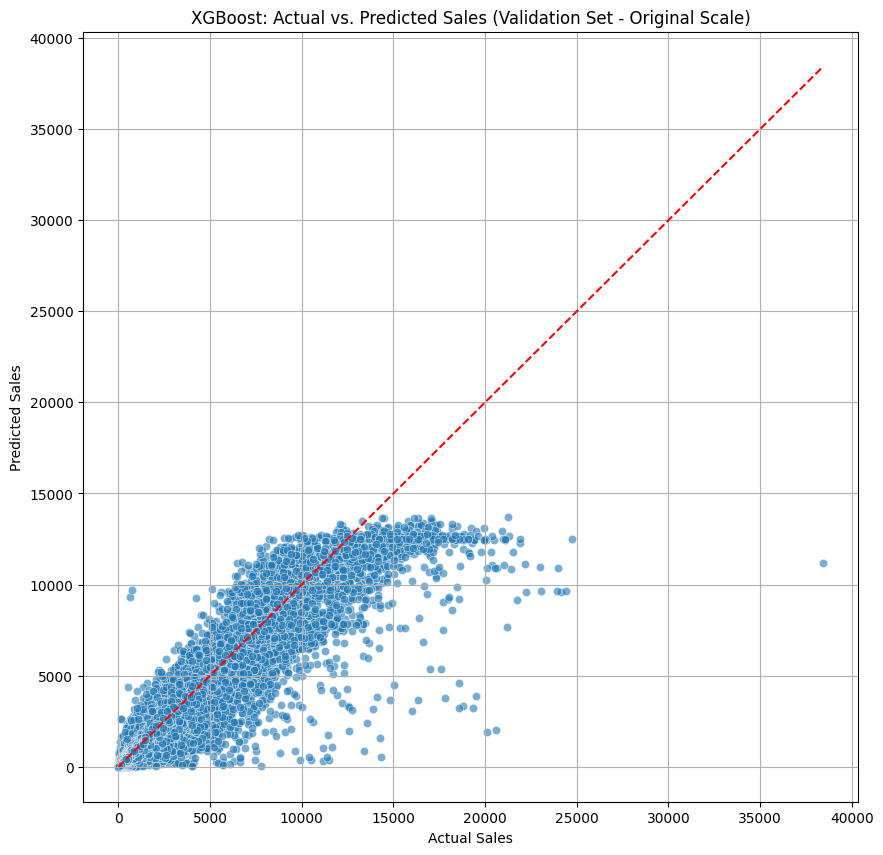

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of actual vs predicted sales on the original scale for XGBoost
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_val_xgb_orig_scale, y=y_pred_xgb_orig_scale, alpha=0.6)

# Add a diagonal line representing perfect predictions
plt.plot([y_val_xgb_orig_scale.min(), y_val_xgb_orig_scale.max()], [y_val_xgb_orig_scale.min(), y_val_xgb_orig_scale.max()], color='red', linestyle='--')

plt.title('XGBoost: Actual vs. Predicted Sales (Validation Set - Original Scale)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Huấn luyện mô hình hồi quy LightGBM
lgbm_regressor = lgb.LGBMRegressor(random_state=42) # Bạn có thể tùy chỉnh tham số
lgbm_regressor.fit(X_train_regression, y_train_regression)

print("Đã huấn luyện mô hình hồi quy LightGBM.")

# Dự đoán trên tập validation
y_pred_lgbm_regression = lgbm_regressor.predict(X_val_regression)

# Chuyển đổi ngược kết quả dự đoán và giá trị thực về thang đo ban đầu
y_pred_lgbm_orig_scale = np.expm1(y_pred_lgbm_regression)
y_val_regression_orig_scale = np.expm1(y_val_regression.values) # Sử dụng y_val_regression

# Đánh giá mô hình LightGBM trên thang đo gốc
mse_lgbm = mean_squared_error(y_val_regression_orig_scale, y_pred_lgbm_orig_scale)
rmse_lgbm = np.sqrt(mse_lgbm)
mae_lgbm = mean_absolute_error(y_val_regression_orig_scale, y_pred_lgbm_orig_scale)
r2_lgbm = r2_score(y_val_regression_orig_scale, y_pred_lgbm_orig_scale)

print(f"\nLightGBM Regression Metrics (Validation Set - Original Scale):")
print(f"  MSE: {mse_lgbm:.2f}")
print(f"  RMSE: {rmse_lgbm:.2f}")
print(f"  MAE: {mae_lgbm:.2f}")
print(f"  R2 Squared: {r2_lgbm:.2f}")

# So sánh với XGBoost (nếu đã chạy ô XGBoost trước đó)
if 'rmse_xgb' in globals():
    print("\nComparison with XGBoost Regression Metrics:")
    print(f"  XGBoost RMSE: {rmse_xgb:.2f}")
    print(f"  LightGBM RMSE: {rmse_lgbm:.2f}")
    print(f"  XGBoost MAE: {mae_xgb:.2f}")
    print(f"  LightGBM MAE: {mae_lgbm:.2f}")
    print(f"  XGBoost R2 Squared: {r2_xgb:.2f}")
    print(f"  LightGBM R2 Squared: {r2_lgbm:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 1641839, number of used features: 39
[LightGBM] [Info] Start training from score 4.265087
Đã huấn luyện mô hình hồi quy LightGBM.

LightGBM Regression Metrics (Validation Set - Original Scale):
  MSE: 161101.83
  RMSE: 401.37
  MAE: 102.47
  R2 Squared: 0.92

Comparison with XGBoost Regression Metrics:
  XGBoost RMSE: 375.27
  LightGBM RMSE: 401.37
  XGBoost MAE: 98.63
  LightGBM MAE: 102.47
  XGBoost R2 Squared: 0.93
  LightGBM R2 Squared: 0.92


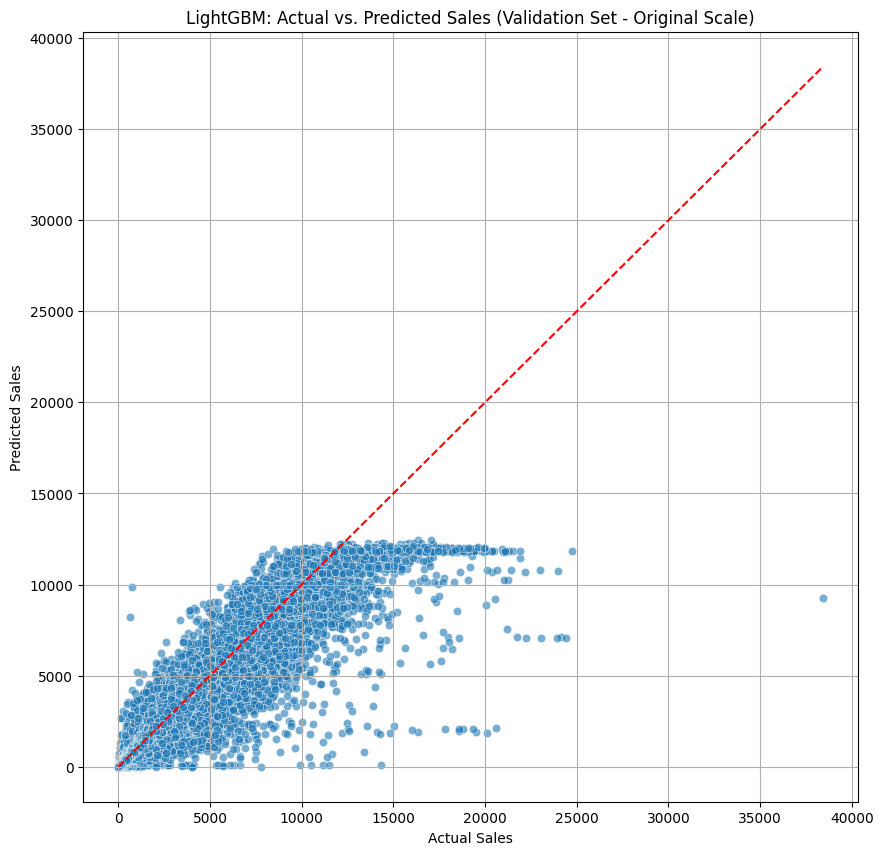

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of actual vs predicted sales on the original scale for LightGBM
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_val_regression_orig_scale, y=y_pred_lgbm_orig_scale, alpha=0.6)

# Add a diagonal line representing perfect predictions
plt.plot([y_val_regression_orig_scale.min(), y_val_regression_orig_scale.max()], [y_val_regression_orig_scale.min(), y_val_regression_orig_scale.max()], color='red', linestyle='--')

plt.title('LightGBM: Actual vs. Predicted Sales (Validation Set - Original Scale)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Huấn luyện mô hình hồi quy Linear Regression
lr_regressor = LinearRegression()
lr_regressor.fit(X_train_regression, y_train_regression)

print("Đã huấn luyện mô hình hồi quy Linear Regression.")

# Dự đoán trên tập validation
y_pred_lr_regression = lr_regressor.predict(X_val_regression)

# Chuyển đổi ngược kết quả dự đoán và giá trị thực về thang đo ban đầu
y_pred_lr_orig_scale = np.expm1(y_pred_lr_regression)
y_val_regression_orig_scale = np.expm1(y_val_regression.values) # Sử dụng y_val_regression

# Đánh giá mô hình Linear Regression trên thang đo gốc
mse_lr = mean_squared_error(y_val_regression_orig_scale, y_pred_lr_orig_scale)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_val_regression_orig_scale, y_pred_lr_orig_scale)
r2_lr = r2_score(y_val_regression_orig_scale, y_pred_lr_orig_scale)

print(f"\nLinear Regression Metrics (Validation Set - Original Scale):")
print(f"  MSE: {mse_lr:.2f}")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  MAE: {mae_lr:.2f}")
print(f"  R2 Squared: {r2_lr:.2f}")

# So sánh với các mô hình trước đó (nếu đã chạy các ô tương ứng)
print("\nComparison with XGBoost and LightGBM Regression Metrics:")
if 'rmse_xgb' in globals():
    print(f"  XGBoost RMSE: {rmse_xgb:.2f}")
if 'rmse_lgbm' in globals():
    print(f"  LightGBM RMSE: {rmse_lgbm:.2f}")
print(f"  Linear Regression RMSE: {rmse_lr:.2f}")

if 'mae_xgb' in globals():
    print(f"  XGBoost MAE: {mae_xgb:.2f}")
if 'mae_lgbm' in globals():
    print(f"  LightGBM MAE: {mae_lgbm:.2f}")
print(f"  Linear Regression MAE: {mae_lr:.2f}")

if 'r2_xgb' in globals():
    print(f"  XGBoost R2 Squared: {r2_xgb:.2f}")
if 'r2_lgbm' in globals():
    print(f"  LightGBM R2 Squared: {r2_lgbm:.2f}")
print(f"  Linear Regression R2 Squared: {r2_lr:.2f}")

Đã huấn luyện mô hình hồi quy Linear Regression.

Linear Regression Metrics (Validation Set - Original Scale):
  MSE: 303423.72
  RMSE: 550.84
  MAE: 128.38
  R2 Squared: 0.86

Comparison with XGBoost and LightGBM Regression Metrics:
  XGBoost RMSE: 375.27
  LightGBM RMSE: 401.37
  Linear Regression RMSE: 550.84
  XGBoost MAE: 98.63
  LightGBM MAE: 102.47
  Linear Regression MAE: 128.38
  XGBoost R2 Squared: 0.93
  LightGBM R2 Squared: 0.92
  Linear Regression R2 Squared: 0.86


In [ ]:
# Bước 5: Kết hợp dự đoán và đánh giá mô hình hai bước trên tập validation

# 1. Dự đoán xác suất có sales bằng mô hình phân loại trên X_val_classification
# Sử dụng predict_proba để lấy xác suất của lớp dương (có sales)
y_pred_proba_val_classification = xgb_classifier.predict_proba(X_val_classification)[:, 1]

# 2. Dự đoán giá trị sales bằng mô hình hồi quy trên X_val_regression (chỉ các hàng có sales > 0)
# y_pred_xgb đã được tính toán trước đó khi đánh giá mô hình hồi quy XGBoost

# 3. Kết hợp dự đoán
# Tạo một mảng dự đoán sales cuối cùng cho toàn bộ tập validation, ban đầu điền 0
y_pred_two_step_val_scaled = np.zeros(X_val_classification.shape[0])

# Xác định ngưỡng để quyết định khi nào sử dụng dự đoán của mô hình hồi quy
# Bạn có thể tinh chỉnh ngưỡng này dựa trên hiệu suất của mô hình phân loại trên tập validation
# Ví dụ: sử dụng ngưỡng 0.5 hoặc tìm ngưỡng tối ưu hóa F1-score/ROC AUC
classification_threshold = 0.5 # Ngưỡng ví dụ, có thể điều chỉnh

# Lấy index của các hàng trong tập validation được mô hình phân loại dự đoán là có sales (dựa trên ngưỡng)
# Cần đảm bảo X_val_classification và val_merged có cùng thứ tự các hàng để lấy đúng index
# Index của X_val_regression tương ứng với index của val_merged[val_merged['has_sales'] == 1]
# val_regression_indices = val_merged[val_merged['has_sales'] == 1].index # This line is not used

# Ánh xạ dự đoán hồi quy trở lại vị trí ban đầu trong tập validation đầy đủ
# Tạo một series với index từ X_val_regression và giá trị dự đoán sales_lag (trên thang đo logarit)
# Ensure the index aligns with the original val_merged index
y_pred_regression_series = pd.Series(xgb_regressor.predict(X_val_regression), index=X_val_regression.index)


# Gán các giá trị dự đoán hồi quy vào mảng dự đoán cuối cùng
# Chỉ gán cho những hàng có sales > 0 trong tập validation ban đầu
# Need to map the indices correctly from the regression subset back to the full validation set
# Create a mapping from the index of X_val_regression to the index of val_merged
val_regression_full_indices = val_merged[val_merged['has_sales'] == 1].index

# Assign the regression predictions to the correct positions in the full prediction array
# The index of y_pred_two_step_val_scaled corresponds to the relative position in X_val_classification
# Need to use the original index from val_merged to align predictions
y_pred_two_step_val_scaled[val_regression_full_indices - val_merged.index[0]] = y_pred_regression_series.values


# Áp dụng ngưỡng phân loại để điều chỉnh dự đoán cuối cùng
# Nếu xác suất có sales dưới ngưỡng, đặt dự đoán sales cuối cùng bằng 0
y_pred_two_step_val_scaled[y_pred_proba_val_classification < classification_threshold] = 0


# 4. Chuyển đổi ngược dự đoán cuối cùng về thang đo ban đầu
y_pred_two_step_val_orig_scale = np.expm1(y_pred_two_step_val_scaled)

# Lấy giá trị sales thực tế từ tập validation (trên thang đo gốc)
# y_val_orig_scale = np.expm1(y_val_regression.values) # y_val_regression only contains sales > 0, need sales of entire val_merged
y_val_full_orig_scale = np.expm1(val_merged['sales'].values)


# 5. Đánh giá mô hình hai bước trên tập validation (thang đo gốc)
# Sử dụng RMSLE (Root Mean Squared Logarithmic Error) - đây thường là metric cho bài toán này
# Cần xử lý các giá trị âm trong dự đoán (đặt về 0) trước khi tính RMSLE
y_pred_two_step_val_orig_scale[y_pred_two_step_val_orig_scale < 0] = 0

# Tính RMSLE
# Sử dụng mean_squared_log_error và sau đó lấy căn bậc hai
rmsle_two_step_val = np.sqrt(mean_squared_log_error(y_val_full_orig_scale, y_pred_two_step_val_orig_scale))


print(f"\nTwo-Step Model Evaluation (Validation Set - Original Scale):")
print(f"  RMSLE: {rmsle_two_step_val:.4f}")

# Bạn cũng có thể tính các chỉ số khác như MSE, RMSE, MAE, R2 trên thang đo gốc nếu cần
mse_two_step_val = mean_squared_error(y_val_full_orig_scale, y_pred_two_step_val_orig_scale)
rmse_two_step_val = np.sqrt(mse_two_step_val)
mae_two_step_val = mean_absolute_error(y_val_full_orig_scale, y_pred_two_step_val_orig_scale)
r2_two_step_val = r2_score(y_val_full_orig_scale, y_pred_two_step_val_orig_scale)

print(f"  MSE: {mse_two_step_val:.2f}")
print(f"  RMSE: {rmse_two_step_val:.2f}")
print(f"  MAE: {mae_two_step_val:.2f}")
print(f"  R2 Squared: {r2_two_step_val:.2f}")

# So sánh với các mô hình hồi quy đơn lẻ nếu cần (lưu ý rằng đây là đánh giá mô hình 2 bước)
print("\nComparison with Single Regression Model (on sales > 0 subset):")
# Ensure these variables are available in the current scope if you want to print them
try:
    if 'rmse_xgb' in globals():
        print(f"  XGBoost Regression (sales>0) RMSE: {rmse_xgb:.2f}")
    if 'rmse_lgbm' in globals():
        print(f"  LightGBM Regression (sales>0) RMSE: {rmse_lgbm:.2f}")
    if 'rmse_lr' in globals():
        print(f"  Linear Regression (sales>0) RMSE: {rmse_lr:.2f}")

    if 'mae_xgb' in globals():
        print(f"  XGBoost MAE: {mae_xgb:.2f}")
    if 'mae_lgbm' in globals():
        print(f"  LightGBM MAE: {mae_lgbm:.2f}")
    if 'mae_lr' in globals():
        print(f"  Linear Regression MAE: {mae_lr:.2f}")

    if 'r2_xgb' in globals():
        print(f"  XGBoost R2 Squared: {r2_xgb:.2f}")
    if 'r2_lgbm' in globals():
        print(f"  LightGBM R2 Squared: {r2_lgbm:.2f}")
    if 'r2_lr' in globals():
        print(f"  Linear Regression R2 Squared: {r2_lr:.2f}")
except NameError as e:
    print(f"Could not print comparison metrics due to missing variables: {e}")


Two-Step Model Evaluation (Validation Set - Original Scale):
  RMSLE: 0.4761
  MSE: 119668.73
  RMSE: 345.93
  MAE: 83.91
  R2 Squared: 0.93

Comparison with Single Regression Model (on sales > 0 subset):
  XGBoost Regression (sales>0) RMSE: 375.27
  LightGBM Regression (sales>0) RMSE: 401.37
  Linear Regression (sales>0) RMSE: 550.84
  XGBoost MAE: 98.63
  LightGBM MAE: 102.47
  Linear Regression MAE: 128.38
  XGBoost R2 Squared: 0.93
  LightGBM R2 Squared: 0.92
  Linear Regression R2 Squared: 0.86


##3.3 Kiểm tra underfit/overfit cho mô hình huấn luyện 2 bước

In [ ]:
# Bước 5.1: Đánh giá mô hình hai bước trên tập huấn luyện để kiểm tra underfit/overfit

# 1. Dự đoán xác suất có sales bằng mô hình phân loại trên X_train_classification
y_pred_proba_train_classification = xgb_classifier.predict_proba(X_train_classification)[:, 1]

# 2. Dự đoán giá trị sales bằng mô hình hồi quy trên X_train_regression (chỉ các hàng có sales > 0 trong tập huấn luyện)
y_pred_regression_train_scaled = xgb_regressor.predict(X_train_regression)


# 3. Kết hợp dự đoán cho tập huấn luyện
# Tạo một mảng dự đoán sales cuối cùng cho toàn bộ tập huấn luyện, ban đầu điền 0
y_pred_two_step_train_scaled = np.zeros(X_train_classification.shape[0])

# Lấy index của các hàng có sales > 0 trong tập huấn luyện ban đầu
train_regression_full_indices = train_merged[train_merged['has_sales'] == 1].index

# Gán các giá trị dự đoán hồi quy vào vị trí đúng trong mảng dự đoán cuối cùng của tập huấn luyện
# Cần ánh xạ index từ X_train_regression trở lại index của train_merged
# The index of X_train_regression is already aligned with train_regression, which is a subset of train_merged
# Need to map the index of train_regression back to the original index of train_merged
# Adjust index by subtracting the minimum index of train_merged to get relative position
relative_indices = train_regression_full_indices - train_merged.index[0]
y_pred_two_step_train_scaled[relative_indices] = y_pred_regression_train_scaled


# Áp dụng ngưỡng phân loại (sử dụng cùng ngưỡng đã dùng cho tập validation)
classification_threshold = 0.5
y_pred_two_step_train_scaled[y_pred_proba_train_classification < classification_threshold] = 0

# 4. Chuyển đổi ngược dự đoán cuối cùng về thang đo ban đầu cho tập huấn luyện
y_pred_two_step_train_orig_scale = np.expm1(y_pred_two_step_train_scaled)

# Lấy giá trị sales thực tế từ tập huấn luyện (trên thang đo gốc)
y_train_full_orig_scale = np.expm1(train_merged['sales'].values)


# 5. Đánh giá mô hình hai bước trên tập huấn luyện (thang đo gốc)
# Cần xử lý các giá trị âm trong dự đoán (đặt về 0) trước khi tính RMSLE, MSE, MAE
y_pred_two_step_train_orig_scale[y_pred_two_step_train_orig_scale < 0] = 0

# Tính các chỉ số trên tập huấn luyện
rmsle_two_step_train = np.sqrt(mean_squared_log_error(y_train_full_orig_scale, y_pred_two_step_train_orig_scale))
mse_two_step_train = mean_squared_error(y_train_full_orig_scale, y_pred_two_step_train_orig_scale)
rmse_two_step_train = np.sqrt(mse_two_step_train)
mae_two_step_train = mean_absolute_error(y_train_full_orig_scale, y_pred_two_step_train_orig_scale)


print(f"\nTwo-Step Model Evaluation (Training Set - Original Scale):")
print(f"  RMSLE: {rmsle_two_step_train:.4f}")
print(f"  MSE: {mse_two_step_train:.2f}")
print(f"  RMSE: {rmse_two_step_train:.2f}")
print(f"  MAE: {mae_two_step_train:.2f}")


print("\nComparison of Metrics on Training and Validation Sets:")
print(f"  RMSLE:")
print(f"    Training: {rmsle_two_step_train:.4f}")
print(f"    Validation: {rmsle_two_step_val:.4f}")

print(f"  RMSE:")
print(f"    Training: {rmse_two_step_train:.2f}")
print(f"    Validation: {rmse_two_step_val:.2f}")

print(f"  MAE:")
print(f"    Training: {mae_two_step_train:.2f}")
print(f"    Validation: {mae_two_step_val:.2f}")


# Phân tích kết quả để kiểm tra underfit/overfit
print("\nAnalysis for Underfitting/Overfitting:")
if rmsle_two_step_train < rmsle_two_step_val:
    print("  Mô hình hoạt động tốt hơn trên tập huấn luyện so với tập validation.")
    # Kiểm tra mức độ chênh lệch
    rmsle_diff = rmsle_two_step_val - rmsle_two_step_train
    rmse_diff = rmse_two_step_val - rmse_two_step_train
    mae_diff = mae_two_step_val - mae_two_step_train

    print(f"  Chênh lệch RMSLE (Validation - Training): {rmsle_diff:.4f}")
    print(f"  Chênh lệch RMSE (Validation - Training): {rmse_diff:.2f}")
    print(f"  Chênh lệch MAE (Validation - Training): {mae_diff:.2f}")


    if rmsle_diff > 0.05 or rmse_diff > 100 or mae_diff > 50: # Ngưỡng chênh lệch có thể điều chỉnh
        print("  Có thể có dấu hiệu của overfitting (hiệu suất trên tập validation kém hơn đáng kể).")
    else:
         print("  Sự khác biệt giữa tập huấn luyện và validation là chấp nhận được.")

elif rmsle_two_step_train > rmsle_two_step_val:
    print("  Mô hình hoạt động tốt hơn trên tập validation so với tập huấn luyện. Điều này không phổ biến và có thể cần kiểm tra lại quy trình hoặc dữ liệu.")
else:
    print("  Mô hình có hiệu suất tương tự trên cả tập huấn luyện và tập validation.")


Two-Step Model Evaluation (Training Set - Original Scale):
  RMSLE: 0.4267
  MSE: 96151.99
  RMSE: 310.08
  MAE: 60.79

Comparison of Metrics on Training and Validation Sets:
  RMSLE:
    Training: 0.4267
    Validation: 0.4761
  RMSE:
    Training: 310.08
    Validation: 345.93
  MAE:
    Training: 60.79
    Validation: 83.91

Analysis for Underfitting/Overfitting:
  Mô hình hoạt động tốt hơn trên tập huấn luyện so với tập validation.
  Chênh lệch RMSLE (Validation - Training): 0.0494
  Chênh lệch RMSE (Validation - Training): 35.85
  Chênh lệch MAE (Validation - Training): 23.11
  Sự khác biệt giữa tập huấn luyện và validation là chấp nhận được.


#4 Chuẩn bị và tiền xử lí dữ liệu cho test

##4.1 Chuẩn bị dữ liệu cho test

In [ ]:
# Define the split date for the test set
test_split_date = pd.to_datetime('2017-08-22')

# Split the test set based on the date
test_part1 = test[test['date'] <= test_split_date].copy()
test_part2 = test[test['date'] > test_split_date].copy()

print(f"Đã chia dữ liệu test gốc thành tập test_part1 (đến {test_split_date.date()}) và tập test_part2 (sau {test_split_date.date()}):")
print("Kích thước tập test_part1:", test_part1.shape)
print("Kích thước tập test_part2:", test_part2.shape)

display(test_part1.head())
display(test_part2.head())

# Check the last date of test_part1 and the first date of test_part2
print("\nNgày cuối cùng của tập test_part1:")
display(test_part1['date'].max())
print("Ngày đầu tiên của tập test_part2:")
display(test_part2['date'].min())

Đã chia dữ liệu test gốc thành tập test_part1 (đến 2017-08-22) và tập test_part2 (sau 2017-08-22):
Kích thước tập test_part1: (12474, 5)
Kích thước tập test_part2: (16038, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


,id,date,store_nbr,family,onpromotion
12474,3013362,2017-08-23,1,AUTOMOTIVE,0
12475,3013363,2017-08-23,1,BABY CARE,0
12476,3013364,2017-08-23,1,BEAUTY,1
12477,3013365,2017-08-23,1,BEVERAGES,27
12478,3013366,2017-08-23,1,BOOKS,0



Ngày cuối cùng của tập test_part1:


Timestamp('2017-08-22 00:00:00')

Ngày đầu tiên của tập test_part2:


Timestamp('2017-08-23 00:00:00')

####4.1.1 Gộp bảng store vào test

In [ ]:
# Gộp bảng test_part1 với stores
test_part1_merged = pd.merge(test_part1, stores, on='store_nbr', how='left')

# Hiển thị vài dòng đầu của các bảng đã gộp
print("Test Part 1 Merged Head sau khi gộp với stores:")
display(test_part1_merged.head())



Test Part 1 Merged Head sau khi gộp với stores:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13


In [ ]:
# Gộp bảng test_part1 với stores
test_part2_merged = pd.merge(test_part2, stores, on='store_nbr', how='left')

print("\nTest Part 2 Merged Head sau khi gộp với stores:")
display(test_part2_merged.head())


Test Part 2 Merged Head sau khi gộp với stores:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13


####4.1.2 Gộp bảng oil vào test

In [ ]:
# Gộp test_part1_merged với oil
test_part1_merged = pd.merge(test_part1_merged, oil, on='date', how='left')

print("\nTest Part 1 Merged Head sau khi gộp với oil:")
display(test_part1_merged.head())


Test Part 1 Merged Head sau khi gộp với oil:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8


In [ ]:
# Gộp test_part2_merged với oil
test_part2_merged = pd.merge(test_part2_merged, oil, on='date', how='left')

print("\nTest Part 2 Merged Head sau khi gộp với oil:")
display(test_part2_merged.head())


Test Part 2 Merged Head sau khi gộp với oil:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45


####4.1.3 Gộp bảng holiday-event vào test

#####Hợp nhất holiday với test part 1 và test part 2

In [ ]:
# Hợp nhất test_part1_merged với holidays
test_part1_merged = pd.merge(test_part1_merged, holidays, on='date', how='left')

# Điền các giá trị NaN trong các cột ngày lễ mới bằng "No Holiday"
for col in holidays.columns:
    if col != 'date':
        test_part1_merged[col] = test_part1_merged[col].fillna('No Holiday')

# Hiển thị Test Part 1 Merged Head sau khi gộp với holidays
print("\nTest Part 1 Merged Head sau khi gộp với holidays:")
display(test_part1_merged.head())


Test Part 1 Merged Head sau khi gộp với holidays:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday


In [ ]:
# Hợp nhất test_part2_merged với holidays
test_part2_merged = pd.merge(test_part2_merged, holidays, on='date', how='left')

# Điền các giá trị NaN trong các cột ngày lễ mới bằng "No Holiday"
for col in holidays.columns:
    if col != 'date':
        test_part2_merged[col] = test_part2_merged[col].fillna('No Holiday')

# Hiển thị Test Part 2 Merged Head sau khi gộp với holidays
print("\nTest Part 2 Merged Head sau khi gộp với holidays:")
display(test_part2_merged.head())


Test Part 2 Merged Head sau khi gộp với holidays:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,transferred
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,No Holiday


#####Xóa cột transferred

In [ ]:
# Xóa cột 'transferred' khỏi test_part1_merged
test_part1_merged = test_part1_merged.drop('transferred', axis=1)
print("Đã xóa cột 'transferred' khỏi test_part1_merged.")
display(test_part1_merged.head())
display(test_part1_merged.tail())

Đã xóa cột 'transferred' khỏi test_part1_merged.


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
12469,3013357,2017-08-22,9,POULTRY,2,Quito,Pichincha,B,6,47.65,No Holiday,No Holiday,No Holiday,No Holiday
12470,3013358,2017-08-22,9,PREPARED FOODS,0,Quito,Pichincha,B,6,47.65,No Holiday,No Holiday,No Holiday,No Holiday
12471,3013359,2017-08-22,9,PRODUCE,146,Quito,Pichincha,B,6,47.65,No Holiday,No Holiday,No Holiday,No Holiday
12472,3013360,2017-08-22,9,SCHOOL AND OFFICE SUPPLIES,8,Quito,Pichincha,B,6,47.65,No Holiday,No Holiday,No Holiday,No Holiday
12473,3013361,2017-08-22,9,SEAFOOD,0,Quito,Pichincha,B,6,47.65,No Holiday,No Holiday,No Holiday,No Holiday


In [ ]:
# Xóa cột 'transferred' khỏi test_part2_merged
test_part2_merged = test_part2_merged.drop('transferred', axis=1)
print("Đã xóa cột 'transferred' khỏi test_part2_merged.")
display(test_part2_merged.head())
display(test_part2_merged.tail())

Đã xóa cột 'transferred' khỏi test_part2_merged.


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
16033,3029395,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6,47.26,No Holiday,No Holiday,No Holiday,No Holiday
16034,3029396,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6,47.26,No Holiday,No Holiday,No Holiday,No Holiday
16035,3029397,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6,47.26,No Holiday,No Holiday,No Holiday,No Holiday
16036,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6,47.26,No Holiday,No Holiday,No Holiday,No Holiday
16037,3029399,2017-08-31,9,SEAFOOD,0,Quito,Pichincha,B,6,47.26,No Holiday,No Holiday,No Holiday,No Holiday


#####Hợp nhất phạm vi ngày lễ

In [ ]:
#Hợp nhất phạm vi ngày lễ cho test_part1_merged
test_part1_merged = merge_holidays_conditional(test_part1_merged, holidays)

print("\nTest Part 1 Merged Head after conditional holiday merge (optimized):")
display(test_part1_merged.head())


Test Part 1 Merged Head after conditional holiday merge (optimized):


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday


In [ ]:
#Hợp nhất phạm vi ngày lễ cho test_part2_merged
test_part2_merged = merge_holidays_conditional(test_part2_merged, holidays)

print("\nTest Part 2 Merged Head after conditional holiday merge (optimized):")
display(test_part2_merged.head())


Test Part 2 Merged Head after conditional holiday merge (optimized):


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday


In [ ]:
# Lọc test_part1_merged cho các dòng có 'Bonus Event' trong cột 'type_hd'
bonus_event_testp1 = test_part1_merged[test_part1_merged['type_hd'] == 'Bonus Event']

print("Dữ liệu cho các ngày có 'Bonus Event' trong test_part1_merged:")
display(bonus_event_testp1)

# Lọc test_part2_merged cho các dòng có 'Bonus Event' trong cột 'type_hd'
bonus_event_testp2 = test_part2_merged[test_part2_merged['type_hd'] == 'Bonus Event']

print("\nDữ liệu cho các ngày có 'Bonus Event' trong test_part2_merged:")
display(bonus_event_testp2)

Dữ liệu cho các ngày có 'Bonus Event' trong test_part1_merged:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description



Dữ liệu cho các ngày có 'Bonus Event' trong test_part2_merged:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description


###4.1.4 Thêm cột is_earthquake và worldcup

In [ ]:
# Tạo cột is_earthquake trong test_part1_merged
test_part1_merged['is_earthquake'] = test_part1_merged['description'].apply(lambda x: 1 if 'Terremoto Manabi' in str(x) else 0)
# Tạo cột is_world_cup trong test_part1_merged
test_part1_merged['world_cup'] = test_part1_merged['description'].apply(lambda x: 1 if 'Mundial de futbol Brasil:' in str(x) else 0)

print("Đã tạo cột 'is_earthquake' và 'world_cup' trong test_part1_merged.")

# Hiển thị một vài dòng đầu để kiểm tra cột mới
display(test_part1_merged.head())

Đã tạo cột 'is_earthquake' và 'world_cup' trong test_part1_merged.


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,0,0
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,0,0
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,0,0
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,No Holiday,No Holiday,No Holiday,No Holiday,0,0


In [ ]:
# Tạo cột is_earthquake trong test_part2_merged
test_part2_merged['is_earthquake'] = test_part2_merged['description'].apply(lambda x: 1 if 'Terremoto Manabi' in str(x) else 0)
# Tạo cột is_world_cup trong test_part2_merged
test_part2_merged['world_cup'] = test_part2_merged['description'].apply(lambda x: 1 if 'Mundial de futbol Brasil:' in str(x) else 0)

print("Đã tạo cột 'is_earthquake' và 'world_cup' trong test_part2_merged.")

# Hiển thị một vài dòng đầu để kiểm tra cột mới
display(test_part2_merged.head())

Đã tạo cột 'is_earthquake' và 'world_cup' trong test_part2_merged.


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,type_hd,locale,locale_name,description,is_earthquake,world_cup
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,0,0
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,0,0
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,0,0
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,0,0
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,No Holiday,No Holiday,No Holiday,No Holiday,0,0


###4.1.5 Tổng quan về dữ liệu sau khi gộp

In [ ]:
test_part1_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12474 entries, 0 to 12473
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             12474 non-null  int64         
 1   date           12474 non-null  datetime64[ns]
 2   store_nbr      12474 non-null  int64         
 3   family         12474 non-null  object        
 4   onpromotion    12474 non-null  int64         
 5   city           12474 non-null  object        
 6   state          12474 non-null  object        
 7   type           12474 non-null  object        
 8   cluster        12474 non-null  int64         
 9   dcoilwtico     8910 non-null   float64       
 10  type_hd        12474 non-null  object        
 11  locale         12474 non-null  object        
 12  locale_name    12474 non-null  object        
 13  description    12474 non-null  object        
 14  is_earthquake  12474 non-null  int64         
 15  world_cup      1247

In [ ]:
test_part2_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16038 entries, 0 to 16037
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             16038 non-null  int64         
 1   date           16038 non-null  datetime64[ns]
 2   store_nbr      16038 non-null  int64         
 3   family         16038 non-null  object        
 4   onpromotion    16038 non-null  int64         
 5   city           16038 non-null  object        
 6   state          16038 non-null  object        
 7   type           16038 non-null  object        
 8   cluster        16038 non-null  int64         
 9   dcoilwtico     12474 non-null  float64       
 10  type_hd        16038 non-null  object        
 11  locale         16038 non-null  object        
 12  locale_name    16038 non-null  object        
 13  description    16038 non-null  object        
 14  is_earthquake  16038 non-null  int64         
 15  world_cup      1603

##4.2 Tiền xử lí dữ liệu cho test

###4.2.1 Fill giá dầu

In [ ]:
# Điền giá trị thiếu trong dcoilwtico cho test_part1_merged bằng ffill trước (sử dụng các giá trị trước đó)
test_part1_merged['dcoilwtico'] = test_part1_merged['dcoilwtico'].fillna(method='ffill')

# Sau đó, điền bất kỳ giá trị NaN còn lại ở đầu test_part1_merged bằng bfill
test_part1_merged['dcoilwtico'] = test_part1_merged['dcoilwtico'].fillna(method='bfill')

# Hiển thị thông tin để kiểm tra số lượng giá trị không bị thiếu cho test_part1_merged
print("Thông tin test_part1_merged sau khi điền giá trị thiếu cho 'dcoilwtico':")
test_part1_merged.info(show_counts=True)

# Tìm ngày đầu tiên trong test_part1_merged
first_test_part1_date = test_part1_merged['date'].min()

# Hiển thị giá dầu vào ngày đầu tiên của tập test_part1
print(f"\nGiá dầu vào ngày đầu tiên của tập test_part1 ({first_test_part1_date.date()}):")
display(test_part1_merged[test_part1_merged['date'] == first_test_part1_date]['dcoilwtico'].iloc[0])

Thông tin test_part1_merged sau khi điền giá trị thiếu cho 'dcoilwtico':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12474 entries, 0 to 12473
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             12474 non-null  int64         
 1   date           12474 non-null  datetime64[ns]
 2   store_nbr      12474 non-null  int64         
 3   family         12474 non-null  object        
 4   onpromotion    12474 non-null  int64         
 5   city           12474 non-null  object        
 6   state          12474 non-null  object        
 7   type           12474 non-null  object        
 8   cluster        12474 non-null  int64         
 9   dcoilwtico     12474 non-null  float64       
 10  type_hd        12474 non-null  object        
 11  locale         12474 non-null  object        
 12  locale_name    12474 non-null  object        
 13  description    12474 non-null  object        
 1

/tmp/ipython-input-4231835077.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_part1_merged['dcoilwtico'] = test_part1_merged['dcoilwtico'].fillna(method='ffill')
/tmp/ipython-input-4231835077.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_part1_merged['dcoilwtico'] = test_part1_merged['dcoilwtico'].fillna(method='bfill')


np.float64(46.8)

In [ ]:
# Điền giá trị thiếu trong dcoilwtico cho test_part2_merged bằng ffill trước (sử dụng các giá trị trước đó)
test_part2_merged['dcoilwtico'] = test_part2_merged['dcoilwtico'].fillna(method='ffill')

# Sau đó, điền bất kỳ giá trị NaN còn lại ở đầu test_part2_merged bằng bfill
test_part2_merged['dcoilwtico'] = test_part2_merged['dcoilwtico'].fillna(method='bfill')

# Hiển thị thông tin để kiểm tra số lượng giá trị không bị thiếu cho test_part2_merged
print("Thông tin test_part2_merged sau khi điền giá trị thiếu cho 'dcoilwtico':")
test_part2_merged.info(show_counts=True)

# Tìm ngày đầu tiên trong test_part2_merged
first_test_part2_date = test_part2_merged['date'].min()

# Hiển thị giá dầu vào ngày đầu tiên của tập test_part2
print(f"\nGiá dầu vào ngày đầu tiên của tập test_part2 ({first_test_part2_date.date()}):")
display(test_part2_merged[test_part2_merged['date'] == first_test_part2_date]['dcoilwtico'].iloc[0])

Thông tin test_part2_merged sau khi điền giá trị thiếu cho 'dcoilwtico':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16038 entries, 0 to 16037
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             16038 non-null  int64         
 1   date           16038 non-null  datetime64[ns]
 2   store_nbr      16038 non-null  int64         
 3   family         16038 non-null  object        
 4   onpromotion    16038 non-null  int64         
 5   city           16038 non-null  object        
 6   state          16038 non-null  object        
 7   type           16038 non-null  object        
 8   cluster        16038 non-null  int64         
 9   dcoilwtico     16038 non-null  float64       
 10  type_hd        16038 non-null  object        
 11  locale         16038 non-null  object        
 12  locale_name    16038 non-null  object        
 13  description    16038 non-null  object        
 1

/tmp/ipython-input-1644523532.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_part2_merged['dcoilwtico'] = test_part2_merged['dcoilwtico'].fillna(method='ffill')
/tmp/ipython-input-1644523532.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_part2_merged['dcoilwtico'] = test_part2_merged['dcoilwtico'].fillna(method='bfill')


np.float64(48.45)

###4.2.2 One-hot encode cho biến ngày lễ/sự kiện dựa trên phạm vi và trực quan hóa

In [ ]:
# Tạo các cột mới để đánh dấu loại ngày cho test_part1_merged
test_part1_merged['is_local_event'] = np.where((test_part1_merged['locale'] == 'Local') & (test_part1_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part1_merged['is_regional_event'] = np.where((test_part1_merged['locale'] == 'Regional') & (test_part1_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part1_merged['is_national_event'] = np.where((test_part1_merged['locale'] == 'National') & (test_part1_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part1_merged['is_bonus_event'] = np.where((test_part1_merged['locale'] == 'Bonus Event') & (test_part1_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part1_merged['is_normal_day'] = np.where(test_part1_merged['type_hd'] == 'No Holiday', 1, 0)

# Hiển thị phần đầu của dataframe test_part1_merged với các cột mới
print("Test Part 1 Merged Head with new holiday event columns:")
display(test_part1_merged.head())

Test Part 1 Merged Head with new holiday event columns:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,locale,locale_name,description,is_earthquake,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1


In [ ]:
# Tạo các cột mới để đánh dấu loại ngày cho test_part2_merged
test_part2_merged['is_local_event'] = np.where((test_part2_merged['locale'] == 'Local') & (test_part2_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part2_merged['is_regional_event'] = np.where((test_part2_merged['locale'] == 'Regional') & (test_part2_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part2_merged['is_national_event'] = np.where((test_part2_merged['locale'] == 'National') & (test_part2_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part2_merged['is_bonus_event'] = np.where((test_part2_merged['locale'] == 'Bonus Event') & (test_part2_merged['type_hd'] != 'No Holiday'), 1, 0)
test_part2_merged['is_normal_day'] = np.where(test_part2_merged['type_hd'] == 'No Holiday', 1, 0)

# Hiển thị phần đầu của dataframe test_part2_merged với các cột mới
print("Test Part 2 Merged Head with new holiday event columns:")
display(test_part2_merged.head())

Test Part 2 Merged Head with new holiday event columns:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,locale,locale_name,description,is_earthquake,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,No Holiday,0,0,0,0,0,0,1


###4.2.3 Đưa kmean_cluster vào test

In [ ]:
# Hợp nhất dataframe city (chứa nhãn cụm) với test_part1_merged
test_part1_merged = pd.merge(test_part1_merged, city[['city', 'kmeans_cluster']], on='city', how='left')
print("\nTest Part 1 Merged Head với K-Means Cluster:")
display(test_part1_merged.head())


Test Part 1 Merged Head với K-Means Cluster:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,locale_name,description,is_earthquake,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1


In [ ]:
# Hợp nhất dataframe city (chứa nhãn cụm) với test_part2_merged
test_part2_merged = pd.merge(test_part2_merged, city[['city', 'kmeans_cluster']], on='city', how='left')
print("\nTest Part 2 Merged Head với K-Means Cluster:")
display(test_part2_merged.head())


Test Part 2 Merged Head với K-Means Cluster:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,locale_name,description,is_earthquake,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,...,No Holiday,No Holiday,0,0,0,0,0,0,1,1


###4.2.4 Chuẩn hóa cột dcoilwtico:Áp dụng Min-Max Scaling

In [ ]:
# Áp dụng cùng scaler đã huấn luyện trên tập train để chuẩn hóa dcoilwtico trên test_part1_merged
test_part1_merged['dcoilwtico_scaled'] = scaler.transform(test_part1_merged[['dcoilwtico']])

# Hiển thị phần đầu của dataframe test_part1_merged với cột đã chuẩn hóa mới
print("Test Part 1 Merged Head with scaled dcoilwtico:")
display(test_part1_merged.head())

Test Part 1 Merged Head with scaled dcoilwtico:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,description,is_earthquake,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,...,No Holiday,0,0,0,0,0,0,1,1,0.244108
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,...,No Holiday,0,0,0,0,0,0,1,1,0.244108
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,...,No Holiday,0,0,0,0,0,0,1,1,0.244108
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,...,No Holiday,0,0,0,0,0,0,1,1,0.244108
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,...,No Holiday,0,0,0,0,0,0,1,1,0.244108


In [ ]:
# Áp dụng cùng scaler đã huấn luyện trên tập train để chuẩn hóa dcoilwtico trên test_part2_merged
test_part2_merged['dcoilwtico_scaled'] = scaler.transform(test_part2_merged[['dcoilwtico']])

# Hiển thị phần đầu của dataframe test_part2_merged với cột đã chuẩn hóa mới
print("Test Part 2 Merged Head with scaled dcoilwtico:")
display(test_part2_merged.head())

Test Part 2 Merged Head with scaled dcoilwtico:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,description,is_earthquake,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,...,No Holiday,0,0,0,0,0,0,1,1,0.26365
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,...,No Holiday,0,0,0,0,0,0,1,1,0.26365
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,...,No Holiday,0,0,0,0,0,0,1,1,0.26365
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,...,No Holiday,0,0,0,0,0,0,1,1,0.26365
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,...,No Holiday,0,0,0,0,0,0,1,1,0.26365


###4.2.5 Áp dụng Label Encoding cho store_nbr và family

In [ ]:
# Áp dụng Label Encoding cho các cột 'store_nbr' và 'family' trên test_part1_merged
# Sử dụng cùng các LabelEncoder đã được huấn luyện trên train_merged
test_part1_merged['store_nbr_encoded'] = store_le.transform(test_part1_merged['store_nbr'])
test_part1_merged['family_encoded'] = family_le.transform(test_part1_merged['family'])

# Hiển thị phần đầu của dataframe test_part1_merged với các cột đã mã hóa mới
print("Test Part 1 Merged Head với các cột 'store_nbr_encoded' và 'family_encoded':")
display(test_part1_merged.head())

Test Part 1 Merged Head với các cột 'store_nbr_encoded' và 'family_encoded':


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,...,0,0,0,0,0,1,1,0.244108,0,0
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,...,0,0,0,0,0,1,1,0.244108,0,1
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,...,0,0,0,0,0,1,1,0.244108,0,2
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,...,0,0,0,0,0,1,1,0.244108,0,3
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,...,0,0,0,0,0,1,1,0.244108,0,4


In [ ]:
# Áp dụng Label Encoding cho các cột 'store_nbr' và 'family' trên test_part2_merged
# Sử dụng cùng các LabelEncoder đã được huấn luyện trên train_merged
test_part2_merged['store_nbr_encoded'] = store_le.transform(test_part2_merged['store_nbr'])
test_part2_merged['family_encoded'] = family_le.transform(test_part2_merged['family'])

# Hiển thị phần đầu của dataframe test_part2_merged với các cột đã mã hóa mới
print("Test Part 2 Merged Head với các cột 'store_nbr_encoded' và 'family_encoded':")
display(test_part2_merged.head())

Test Part 2 Merged Head với các cột 'store_nbr_encoded' và 'family_encoded':


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,world_cup,is_local_event,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,...,0,0,0,0,0,1,1,0.26365,0,0
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,...,0,0,0,0,0,1,1,0.26365,0,1
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,...,0,0,0,0,0,1,1,0.26365,0,2
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,...,0,0,0,0,0,1,1,0.26365,0,3
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,...,0,0,0,0,0,1,1,0.26365,0,4


###4.2.6 Trích xuất đặc trưng thời gian từ cột date

In [ ]:
# Trích xuất các đặc trưng dựa trên thời gian cho test_part1_merged
test_part1_merged['month'] = test_part1_merged['date'].dt.month          # Trích xuất tháng
test_part1_merged['is_weekend'] = (test_part1_merged['date'].dt.dayofweek >= 5).astype(int) # Tạo biến nhị phân: 1 nếu là cuối tuần (Thứ 7 hoặc Chủ Nhật), 0 nếu là ngày thường

print("\nTest Part 1 Merged Head với các đặc trưng thời gian đã chọn:")
display(test_part1_merged.head())


Test Part 1 Merged Head với các đặc trưng thời gian đã chọn:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded,month,is_weekend
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,...,0,0,0,1,1,0.244108,0,0,8,0
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,...,0,0,0,1,1,0.244108,0,1,8,0
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,...,0,0,0,1,1,0.244108,0,2,8,0
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,...,0,0,0,1,1,0.244108,0,3,8,0
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,...,0,0,0,1,1,0.244108,0,4,8,0


In [ ]:
# Trích xuất các đặc trưng dựa trên thời gian cho test_part2_merged
test_part2_merged['month'] = test_part2_merged['date'].dt.month          # Trích xuất tháng
test_part2_merged['is_weekend'] = (test_part2_merged['date'].dt.dayofweek >= 5).astype(int) # Tạo biến nhị phân: 1 nếu là cuối tuần (Thứ 7 hoặc Chủ Nhật), 0 nếu là ngày thường

print("\nTest Part 2 Merged Head với các đặc trưng thời gian đã chọn:")
display(test_part2_merged.head())


Test Part 2 Merged Head với các đặc trưng thời gian đã chọn:


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,...,is_regional_event,is_national_event,is_bonus_event,is_normal_day,kmeans_cluster,dcoilwtico_scaled,store_nbr_encoded,family_encoded,month,is_weekend
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,48.45,...,0,0,0,1,1,0.26365,0,0,8,0
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,D,13,48.45,...,0,0,0,1,1,0.26365,0,1,8,0
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,D,13,48.45,...,0,0,0,1,1,0.26365,0,2,8,0
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,D,13,48.45,...,0,0,0,1,1,0.26365,0,3,8,0
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,D,13,48.45,...,0,0,0,1,1,0.26365,0,4,8,0


###4.2.7 One-Hot Encoding cho month, type và type_hd (với giá trị 1/0)

In [ ]:
# Tạo cột month_8 và fill bằng 1
test_part1_merged['month_8'] = 1

# Tạo các cột month_2..month_12 (trừ month_8 vì đã có) và fill bằng 0
for m in [2,3,4,5,6,7,9,10,11,12]:
    test_part1_merged[f'month_{m}'] = 0

# Sắp xếp lại thứ tự các cột theo chiều tăng dần month_2..month_12
month_cols = [f'month_{m}' for m in range(2, 13)]  # ['month_2', 'month_3', ..., 'month_12']
other_cols = [c for c in test_part1_merged.columns if c not in month_cols]

# Đặt lại thứ tự: các cột khác + month_2..month_12
test_part1_merged = test_part1_merged[other_cols + month_cols]
test_part1_merged=test_part1_merged.drop(columns=['month'])

# Kiểm tra kết quả
print(test_part1_merged.head())
test_part1_merged.info(show_counts=True)

        id       date  store_nbr      family  onpromotion   city      state  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889 2017-08-16          1   BABY CARE            0  Quito  Pichincha   
2  3000890 2017-08-16          1      BEAUTY            2  Quito  Pichincha   
3  3000891 2017-08-16          1   BEVERAGES           20  Quito  Pichincha   
4  3000892 2017-08-16          1       BOOKS            0  Quito  Pichincha   

  type  cluster  dcoilwtico  ... month_3 month_4 month_5 month_6  month_7  \
0    D       13        46.8  ...       0       0       0       0        0   
1    D       13        46.8  ...       0       0       0       0        0   
2    D       13        46.8  ...       0       0       0       0        0   
3    D       13        46.8  ...       0       0       0       0        0   
4    D       13        46.8  ...       0       0       0       0        0   

   month_8  month_9  month_10  month_11  month_12  
0        1

In [ ]:
# Tạo cột month_8 và fill bằng 1
test_part2_merged['month_8'] = 1

# Tạo các cột month_2..month_12 (trừ month_8 vì đã có) và fill bằng 0
for m in [2,3,4,5,6,7,9,10,11,12]:
    test_part2_merged[f'month_{m}'] = 0

# Sắp xếp lại thứ tự các cột theo chiều tăng dần month_2..month_12
month_cols = [f'month_{m}' for m in range(2, 13)]  # ['month_2', 'month_3', ..., 'month_12']
other_cols = [c for c in test_part2_merged.columns if c not in month_cols]

# Đặt lại thứ tự: các cột khác + month_2..month_12
test_part2_merged = test_part2_merged[other_cols + month_cols]
test_part2_merged=test_part2_merged.drop(columns=['month'])
# Kiểm tra kết quả
print(test_part2_merged.head())

        id       date  store_nbr      family  onpromotion   city      state  \
0  3013362 2017-08-23          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3013363 2017-08-23          1   BABY CARE            0  Quito  Pichincha   
2  3013364 2017-08-23          1      BEAUTY            1  Quito  Pichincha   
3  3013365 2017-08-23          1   BEVERAGES           27  Quito  Pichincha   
4  3013366 2017-08-23          1       BOOKS            0  Quito  Pichincha   

  type  cluster  dcoilwtico  ... month_3 month_4 month_5 month_6  month_7  \
0    D       13       48.45  ...       0       0       0       0        0   
1    D       13       48.45  ...       0       0       0       0        0   
2    D       13       48.45  ...       0       0       0       0        0   
3    D       13       48.45  ...       0       0       0       0        0   
4    D       13       48.45  ...       0       0       0       0        0   

   month_8  month_9  month_10  month_11  month_12  
0        1

In [ ]:
# Áp dụng One-Hot Encoding cho cột 'type' và 'type_hd' trong test_part1_merged
test_part1_merged_dummies = pd.get_dummies(test_part1_merged, columns=['type', 'type_hd'], drop_first=True)

# Xác định các cột bị thiếu trong test_part1_merged so với train_merged
missing_cols_in_test = set(train_merged.columns) - set(test_part1_merged_dummies.columns)

# Thêm các cột bị thiếu vào test_part1_merged_dummies và điền giá trị 0
for col in missing_cols_in_test:
    # Chỉ thêm các cột là biến giả cho 'type_hd' hoặc 'type'
    if 'type_hd_' in col or 'type_' in col:
        test_part1_merged_dummies[col] = 0
# Chuyển đổi các cột biến giả mới sang kiểu số nguyên (1/0)
for col in test_part1_merged_dummies.columns:
    # Kiểm tra xem đây có phải là cột biến giả mới hoặc cột gốc đã được xử lý không
    # if col not in test_part1_merged.columns or col in ['month']: # This check is not needed here
         # Chỉ chuyển đổi nếu cột là kiểu boolean (biến giả mới)
        if test_part1_merged_dummies[col].dtype == 'bool':
             test_part1_merged_dummies[col] = test_part1_merged_dummies[col].astype(int)


# Cập nhật test_part1_merged với các cột đã được mã hóa và xử lý cột bị thiếu
test_part1_merged = test_part1_merged_dummies.copy()

print("\nTest Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):")
display(test_part1_merged.head())


Test Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):


,id,date,store_nbr,family,onpromotion,city,state,cluster,dcoilwtico,locale,...,type_C,type_D,type_E,type_hd_Bonus Event,type_hd_Transfer,type_hd_Holiday,type_hd_Event,type_hd_No Holiday,type_hd_Work Day,type_hd_Bridge
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,13,46.8,No Holiday,...,0,1,0,0,0,0,0,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,13,46.8,No Holiday,...,0,1,0,0,0,0,0,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,13,46.8,No Holiday,...,0,1,0,0,0,0,0,0,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,13,46.8,No Holiday,...,0,1,0,0,0,0,0,0,0,0
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,13,46.8,No Holiday,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Áp dụng One-Hot Encoding cho cột 'type' và 'type_hd' trong test_part2_merged
test_part2_merged_dummies = pd.get_dummies(test_part2_merged, columns=['type', 'type_hd'], drop_first=True)

# Xác định các cột bị thiếu trong test_part1_merged so với train_merged
missing_cols_in_test = set(train_merged.columns) - set(test_part2_merged_dummies.columns)

# Thêm các cột bị thiếu vào test_part1_merged_dummies và điền giá trị 0
for col in missing_cols_in_test:
    # Chỉ thêm các cột là biến giả cho 'type_hd' hoặc 'type'
    if 'type_hd_' in col or 'type_' in col:
        test_part2_merged_dummies[col] = 0
# Chuyển đổi các cột biến giả mới sang kiểu số nguyên (1/0)
for col in test_part2_merged_dummies.columns:
    # Kiểm tra xem đây có phải là cột biến giả mới hoặc cột gốc đã được xử lý không
    # if col not in test_part1_merged.columns or col in ['month']: # This check is not needed here
         # Chỉ chuyển đổi nếu cột là kiểu boolean (biến giả mới)
        if test_part2_merged_dummies[col].dtype == 'bool':
             test_part2_merged_dummies[col] = test_part2_merged_dummies[col].astype(int)


# Cập nhật test_part1_merged với các cột đã được mã hóa và xử lý cột bị thiếu
test_part2_merged = test_part2_merged_dummies.copy()

print("\nTest Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):")
display(test_part2_merged.head())


Test Merged Head sau khi One-Hot Encoding 'type' và 'type_hd' (giá trị 1/0):


,id,date,store_nbr,family,onpromotion,city,state,cluster,dcoilwtico,locale,...,type_C,type_D,type_E,type_hd_No Holiday,type_hd_Bonus Event,type_hd_Transfer,type_hd_Holiday,type_hd_Event,type_hd_Work Day,type_hd_Bridge
0,3013362,2017-08-23,1,AUTOMOTIVE,0,Quito,Pichincha,13,48.45,No Holiday,...,0,1,0,1,0,0,0,0,0,0
1,3013363,2017-08-23,1,BABY CARE,0,Quito,Pichincha,13,48.45,No Holiday,...,0,1,0,1,0,0,0,0,0,0
2,3013364,2017-08-23,1,BEAUTY,1,Quito,Pichincha,13,48.45,No Holiday,...,0,1,0,1,0,0,0,0,0,0
3,3013365,2017-08-23,1,BEVERAGES,27,Quito,Pichincha,13,48.45,No Holiday,...,0,1,0,1,0,0,0,0,0,0
4,3013366,2017-08-23,1,BOOKS,0,Quito,Pichincha,13,48.45,No Holiday,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
train_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2435994 entries, 160380 to 2596373
Data columns (total 44 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   2435994 non-null  int64         
 1   date                 2435994 non-null  datetime64[ns]
 2   sales                2435994 non-null  float64       
 3   onpromotion          2435994 non-null  int64         
 4   cluster              2435994 non-null  int64         
 5   dcoilwtico           2435994 non-null  float64       
 6   is_earthquake        2435994 non-null  int64         
 7   world_cup            2435994 non-null  int64         
 8   has_sales            2435994 non-null  float64       
 9   is_local_event       2435994 non-null  int64         
 10  is_regional_event    2435994 non-null  int64         
 11  is_national_event    2435994 non-null  int64         
 12  is_bonus_event       2435994 non-null  int64         
 1

In [ ]:
val_merged.info(show_counts=True)
test_part1_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 404514 entries, 2596374 to 3000887
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   404514 non-null  int64         
 1   date                 404514 non-null  datetime64[ns]
 2   sales                404514 non-null  float64       
 3   onpromotion          404514 non-null  int64         
 4   cluster              404514 non-null  int64         
 5   dcoilwtico           404514 non-null  float64       
 6   is_earthquake        404514 non-null  int64         
 7   world_cup            404514 non-null  int64         
 8   has_sales            404514 non-null  float64       
 9   is_local_event       404514 non-null  int64         
 10  is_regional_event    404514 non-null  int64         
 11  is_national_event    404514 non-null  int64         
 12  is_bonus_event       404514 non-null  int64         
 13  is_normal_da

In [ ]:
# Lấy danh sách các cột có kiểu dữ liệu 'object'
object_cols = test_part1_merged.select_dtypes(include=['object']).columns

# Thêm cột 'store_nbr' vào danh sách cần xóa
cols_to_drop = list(object_cols) + ['store_nbr']+['dcoilwtico']

# Xóa các cột đã xác định khỏi DataFrame
test_part1_merged = test_part1_merged.drop(columns=cols_to_drop, errors='ignore')

# Hiển thị thông tin DataFrame để xác minh các cột đã được xóa
print("Các cột còn lại sau khi xóa:")
print(test_part1_merged.info())

Các cột còn lại sau khi xóa:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12474 entries, 0 to 12473
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   12474 non-null  int64         
 1   date                 12474 non-null  datetime64[ns]
 2   onpromotion          12474 non-null  int64         
 3   cluster              12474 non-null  int64         
 4   is_earthquake        12474 non-null  int64         
 5   world_cup            12474 non-null  int64         
 6   is_local_event       12474 non-null  int64         
 7   is_regional_event    12474 non-null  int64         
 8   is_national_event    12474 non-null  int64         
 9   is_bonus_event       12474 non-null  int64         
 10  is_normal_day        12474 non-null  int64         
 11  kmeans_cluster       12474 non-null  int32         
 12  dcoilwtico_scaled    12474 non-null  float64       
 13  st

In [ ]:
# Lấy danh sách các cột có kiểu dữ liệu 'object'
object_cols = test_part2_merged.select_dtypes(include=['object']).columns

# Thêm cột 'store_nbr' vào danh sách cần xóa
cols_to_drop = list(object_cols) + ['store_nbr']+['dcoilwtico']

# Xóa các cột đã xác định khỏi DataFrame
test_part2_merged = test_part2_merged.drop(columns=cols_to_drop, errors='ignore')

# Hiển thị thông tin DataFrame để xác minh các cột đã được xóa
print("Các cột còn lại sau khi xóa:")
print(test_part2_merged.info())

Các cột còn lại sau khi xóa:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16038 entries, 0 to 16037
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   16038 non-null  int64         
 1   date                 16038 non-null  datetime64[ns]
 2   onpromotion          16038 non-null  int64         
 3   cluster              16038 non-null  int64         
 4   is_earthquake        16038 non-null  int64         
 5   world_cup            16038 non-null  int64         
 6   is_local_event       16038 non-null  int64         
 7   is_regional_event    16038 non-null  int64         
 8   is_national_event    16038 non-null  int64         
 9   is_bonus_event       16038 non-null  int64         
 10  is_normal_day        16038 non-null  int64         
 11  kmeans_cluster       16038 non-null  int32         
 12  dcoilwtico_scaled    16038 non-null  float64       
 13  st

###4.2.8 Tạo biến Sales Lag

In [ ]:
# Lưu lại ngày cuối cùng của tập train và val để tách sau này
# Cần đảm bảo cột 'date' có mặt trong train_merged và val_merged
last_train_date = train_merged['date'].max()
last_val_date = val_merged['date'].max()


# Đảm bảo test_merged có cột 'sales' với giá trị NaN để có cùng cấu trúc cho việc nối
if 'sales' not in test_part1_merged.columns:
    test_part1_merged['sales'] = np.nan

# Nối (concat) train_merged, val_merged và test_merged theo chiều dọc
# ignore_index=False để giữ lại index gốc (vốn chứa id)
all_data = pd.concat([train_merged, val_merged, test_part1_merged], ignore_index=False)

# Sắp xếp dữ liệu gộp theo store_nbr_encoded, family_encoded và date
# Việc sắp xếp này đảm bảo rằng các giá trị lag được tính toán đúng thứ tự thời gian
all_data = all_data.sort_values(by=['store_nbr_encoded', 'family_encoded', 'date'])

# Tính toán các đặc trưng lag trên dữ liệu gộp, nhóm theo store_nbr_encoded và family_encoded
all_data['sales_lag_7'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(7)
all_data['sales_lag_30'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(30)
all_data['sales_lag_quarter'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(90)


# Tách lại thành train_merged, val_merged và test_merged dựa trên ngày
train_merged = all_data[all_data['date'] <= last_train_date].copy()
val_merged = all_data[(all_data['date'] > last_train_date) & (all_data['date'] <= last_val_date)].copy()
test_part1_merged = all_data[all_data['date'] > last_val_date].copy()


# Sắp xếp lại các dataframe theo id gốc để khôi phục thứ tự ban đầu (nếu cột id còn tồn tại)
# Cột id đã được bảo toàn do ignore_index=False
if 'id' in train_merged.columns:
    train_merged = train_merged.sort_values(by='id')
if 'id' in val_merged.columns:
    val_merged = val_merged.sort_values(by='id')
if 'id' in test_part1_merged.columns:
    test_part1_merged = test_part1_merged.sort_values(by='id')


# Loại bỏ cột 'sales' khỏi test_merged vì đây là tập test thực tế
test_part1_merged = test_part1_merged.drop('sales', axis=1)

# Hiển thị phần đầu của các dataframe mới với các đặc trưng lag
print("Train Merged Head sau khi tạo lag:")
display(train_merged.head())

print("\nVal Merged Head sau khi tạo lag:")
display(val_merged.head())

print("\nTest part 1 Merged Head sau khi tạo lag:")
display(test_part1_merged.head())

# Kiểm tra các giá trị NaN ở đầu val_merged và test_part1_merged
print("\nChecking for NaNs in sales_lag_7 in the first few rows of val_merged:")
display(val_merged.head(10)[['date', 'store_nbr_encoded', 'family_encoded', 'sales_lag_7']])

print("\nChecking for NaNs in sales_lag_7 in the first few rows of test_merged:")
display(test_part1_merged.head(10)[['date', 'store_nbr_encoded', 'family_encoded', 'sales_lag_7']])

In [ ]:
train_merged.info(show_counts=True)

In [ ]:
test_part1_merged.info(show_counts=True)

#5 Sử dụng mô hình 2 bước dự đoán test part 1


##5.1 Mô hình phân loại


In [ ]:
# Danh sách các cột cần loại bỏ khỏi tập đặc trưng cho mô hình phân loại
# Đây phải là các cột không dùng làm đặc trưng, bao gồm cả biến mục tiêu sales và has_sales
features_to_drop_classification = ['sales', 'date', 'id', 'has_sales', 'dcoilwtico'] # Loại bỏ dcoilwtico gốc, giữ lại scaled

# Chuẩn bị dữ liệu cho mô hình phân loại từ test_part1_merged
X_testp1_classification = test_part1_merged.drop(features_to_drop_classification, axis=1, errors='ignore')
y_testp1_classification = test_part1_merged['has_sales']
# Dự đoán trên tập test part 1 cho mô hình phân loại
y_pred_testp1_classification = xgb_classifier.predict(X_testp1_classification)
y_pred_proba_testp1_classification = xgb_classifier.predict_proba(X_testp1_classification)[:, 1] # Xác suất của lớp dương (có sales)

print("Đã hoàn thành dự đoán trên tập test part 2 cho mô hình phân loại.")

Đã hoàn thành dự đoán trên tập test part 2 cho mô hình phân loại.


In [ ]:
# Gán kết quả dự đoán vào một cột mới trong DataFrame test_part1_merged
test_part1_merged['predicted_has_sales'] = y_pred_testp1_classification

##5.2 Mô hình hồi quy

In [ ]:
# Bước 1: Lọc dữ liệu test_part1_merged
# Bạn cần cột chứa kết quả dự đoán từ mô hình phân loại (ví dụ: 'predicted_has_sales')
# Giả sử bạn đã thực hiện bước này ở phần trước.
test_part1_regression = test_part1_merged[test_part1_merged['predicted_has_sales'] == 1].copy()

# Bước 2: Chuẩn bị đặc trưng cho mô hình hồi quy
# Tương tự như X_train_regression, bạn cần drop các cột không dùng
features_to_drop_regression = [ 'date', 'id', 'has_sales', 'predicted_has_sales']
X_testp1_regression = test_part1_regression.drop(features_to_drop_regression, axis=1)
# Xóa cột thừa trước khi dự đoán
if 'dcoilwtico' in X_testp1_regression.columns:
    X_testp1_regression = X_testp1_regression.drop('dcoilwtico', axis=1)

# Chạy lại đoạn code dự đoán
predicted_sales_filtered =xgb_regressor.predict(X_testp1_regression)
# Thêm bước để xử lý các cột có kiểu object
# Lấy danh sách các cột có kiểu dữ liệu 'object'
object_cols = X_testp1_regression.select_dtypes(include=['object']).columns

# Drop các cột này
X_testp1_regression = X_testp1_regression.drop(columns=object_cols)

# Bước 3: Dự đoán sales cho các dòng đã lọc
# Sử dụng mô hình hồi quy đã huấn luyện (giả sử tên là 'regression_model')
predicted_sales_filtered = xgb_regressor.predict(X_testp1_regression)

In [ ]:

# np.expm1() là hàm nghịch đảo của np.log1p()
predicted_sales = np.expm1(predicted_sales_filtered)

# Sau đó, thêm cột sales đã được dự đoán vào DataFrame test_part1_merged ban đầu
# Đảm bảo bạn đang sử dụng DataFrame test_part1_merged gốc trước khi lọc.
# Tuy nhiên, nếu bạn chỉ muốn thêm vào những dòng đã được dự đoán,
# thì bạn cần tạo một bản sao của DataFrame đó để không bị lỗi.
# Dưới đây là cách gán giá trị dự đoán cho các dòng đã được lọc.

# Bước 1: Lấy các chỉ số (index) của các dòng đã được lọc
# Chúng ta sẽ sử dụng DataFrame test_part1_merged ban đầu để tìm các chỉ số
# của các dòng mà mô hình đã dự đoán.
index_of_predicted_rows = test_part1_merged[test_part1_merged['predicted_has_sales'] == 1].index

# Bước 2: Tạo một cột 'sales' mới trong DataFrame test_part1_merged ban đầu và gán giá trị mặc định là 0
# Những dòng không có bán hàng sẽ có giá trị là 0
test_part1_merged['sales'] = 0

# Bước 3: Gán các giá trị sales đã dự đoán vào các dòng tương ứng
# Sử dụng .loc[] để gán giá trị một cách an toàn dựa trên chỉ số.
test_part1_merged.loc[index_of_predicted_rows, 'sales'] = predicted_sales

print("Đã thêm cột 'sales' với các giá trị đã dự đoán vào DataFrame test_part1_merged.")
print(test_part1_merged[['sales', 'predicted_has_sales']].head())

Đã thêm cột 'sales' với các giá trị đã dự đoán vào DataFrame test_part1_merged.
         sales  predicted_has_sales
0     4.252957                    1
1     0.000000                    0
2     5.532904                    1
3  2355.481689                    1
4     0.000000                    0


/tmp/ipython-input-261528990.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[   4.2529573    5.532904  2355.4817    ... 2171.8801      69.36728
   14.26021  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_part1_merged.loc[index_of_predicted_rows, 'sales'] = predicted_sales


In [ ]:
df_final = test_part1_merged.copy()
df_final.to_excel('submission_forecast_part1.xlsx', index=False)

print("Đã xuất kết quả ra file 'submission_forecast_part1.xlsx' thành công.")

Đã xuất kết quả ra file 'submission_forecast_part1.xlsx' thành công.


#6 Mô hình phân loại và hồi qui dự báo cho test part 2 phần 1

##6.1 Chuẩn bị dữ liệu

In [ ]:
# Lưu lại ngày cuối cùng của tập val và test1 để tách sau này
# Cần đảm bảo cột 'date' có mặt trong val_merged và test_part1_merged
last_val_date = val_merged['date'].max()
last_testp1_date = test_part1_merged['date'].max()

# Đảm bảo test_part2_merged có cột 'sales' với giá trị NaN để có cùng cấu trúc cho việc nối
if 'sales' not in test_part2_merged.columns:
    test_part2_merged['sales'] = np.nan

# Nối (concat) train_merged, val_merged và test_merged theo chiều dọc
# ignore_index=False để giữ lại index gốc (vốn chứa id)
all_data = pd.concat([val_merged, test_part1_merged, test_part2_merged], ignore_index=False)

# Sắp xếp dữ liệu gộp theo store_nbr_encoded, family_encoded và date
# Việc sắp xếp này đảm bảo rằng các giá trị lag được tính toán đúng thứ tự thời gian
all_data = all_data.sort_values(by=['store_nbr_encoded', 'family_encoded', 'date'])

# Tính toán các đặc trưng lag trên dữ liệu gộp, nhóm theo store_nbr_encoded và family_encoded
all_data['sales_lag_7'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(7)
all_data['sales_lag_30'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(30)
all_data['sales_lag_quarter'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(90)


# Tách lại thành train_merged, val_merged và test_merged dựa trên ngày
val_merged = all_data[all_data['date'] <= last_val_date].copy()
test_part1_merged = all_data[(all_data['date'] > last_val_date) & (all_data['date'] <= last_testp1_date)].copy()
test_part2_merged = all_data[all_data['date'] > last_testp1_date].copy()


# Sắp xếp lại các dataframe theo id gốc để khôi phục thứ tự ban đầu (nếu cột id còn tồn tại)
# Cột id đã được bảo toàn do ignore_index=False
if 'id' in val_merged.columns:
    val_merged = val_merged.sort_values(by='id')
if 'id' in test_part1_merged.columns:
    test_part1_merged = test_part1_merged.sort_values(by='id')
if 'id' in test_part2_merged.columns:
    test_part2_merged = test_part2_merged.sort_values(by='id')

# Loại bỏ cột 'sales' khỏi test_merged vì đây là tập test thực tế
test_part2_merged = test_part2_merged.drop('sales', axis=1)

# Hiển thị phần đầu của các dataframe mới với các đặc trưng lag

print("\nVal Merged Head sau khi tạo lag:")
display(val_merged.head())

print("\nTest part 1 Merged Head sau khi tạo lag:")
display(test_part1_merged.head())

print("\nTest part 2 Merged Head sau khi tạo lag:")
display(test_part2_merged.head())

# Kiểm tra các giá trị NaN ở đầu val_merged và test_part1_merged
print("\nChecking for NaNs in sales_lag_7 in the first few rows of val_merged:")
display(val_merged.head(10)[['date', 'store_nbr_encoded', 'family_encoded', 'sales_lag_7']])

print("\nChecking for NaNs in sales_lag_7 in the first few rows of test_merged:")
display(test_part1_merged.head(10)[['date', 'store_nbr_encoded', 'family_encoded', 'sales_lag_7']])


Val Merged Head sau khi tạo lag:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
2596374,2596374,2017-01-01,0.0,0,13,52.36,0,0,0.0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
2596375,2596375,2017-01-01,0.0,0,13,52.36,0,0,0.0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
2596376,2596376,2017-01-01,0.0,0,13,52.36,0,0,0.0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
2596377,2596377,2017-01-01,0.0,0,13,52.36,0,0,0.0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
2596378,2596378,2017-01-01,0.0,0,13,52.36,0,0,0.0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN



Test part 1 Merged Head sau khi tạo lag:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
0,3000888,2017-08-16,4.252957,0,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,2.079442,1.098612,1.609438,1.0
1,3000889,2017-08-16,0.000000,0,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0
2,3000890,2017-08-16,5.532904,2,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,1.609438,1.791759,1.098612,1.0
3,3000891,2017-08-16,2355.481689,20,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,7.745868,7.775696,7.675546,1.0
4,3000892,2017-08-16,0.000000,0,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,0.000000,0.693147,0.000000,0.0



Test part 2 Merged Head sau khi tạo lag:


,id,date,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,is_regional_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
0,3013362,2017-08-23,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,4.252957,1.609438,1.098612,NaN
1,3013363,2017-08-23,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,NaN
2,3013364,2017-08-23,1,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,5.532904,0.693147,0.693147,NaN
3,3013365,2017-08-23,27,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,2355.481689,7.677400,7.709757,NaN
4,3013366,2017-08-23,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,NaN



Checking for NaNs in sales_lag_7 in the first few rows of val_merged:


,date,store_nbr_encoded,family_encoded,sales_lag_7
2596374,2017-01-01,0,0,NaN
2596375,2017-01-01,0,1,NaN
2596376,2017-01-01,0,2,NaN
2596377,2017-01-01,0,3,NaN
2596378,2017-01-01,0,4,NaN
2596379,2017-01-01,0,5,NaN
2596380,2017-01-01,0,6,NaN
2596381,2017-01-01,0,7,NaN
2596382,2017-01-01,0,8,NaN
2596383,2017-01-01,0,9,NaN



Checking for NaNs in sales_lag_7 in the first few rows of test_merged:


,date,store_nbr_encoded,family_encoded,sales_lag_7
0,2017-08-16,0,0,2.079442
1,2017-08-16,0,1,0.000000
2,2017-08-16,0,2,1.609438
3,2017-08-16,0,3,7.745868
4,2017-08-16,0,4,0.000000
5,2017-08-16,0,5,5.992831
6,2017-08-16,0,6,2.564949
7,2017-08-16,0,7,6.480045
8,2017-08-16,0,8,6.672033
9,2017-08-16,0,9,4.824274


In [ ]:
test_part2_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 16038 entries, 0 to 16037
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   16038 non-null  int64         
 1   date                 16038 non-null  datetime64[ns]
 2   onpromotion          16038 non-null  int64         
 3   cluster              16038 non-null  int64         
 4   dcoilwtico           0 non-null      float64       
 5   is_earthquake        16038 non-null  int64         
 6   world_cup            16038 non-null  int64         
 7   has_sales            0 non-null      float64       
 8   is_local_event       16038 non-null  int64         
 9   is_regional_event    16038 non-null  int64         
 10  is_national_event    16038 non-null  int64         
 11  is_bonus_event       16038 non-null  int64         
 12  is_normal_day        16038 non-null  int64         
 13  kmeans_cluster       16038 non-null 

In [ ]:
# Define the split date for test_part2_merged
split_date_test_part2 = pd.to_datetime('2017-08-29')

# Split test_part2_merged into two parts based on the date
test_part2_merged_part1 = test_part2_merged[test_part2_merged['date'] <= split_date_test_part2].copy()
test_part2_merged_part2 = test_part2_merged[test_part2_merged['date'] > split_date_test_part2].copy()

print(f"Đã chia test_part2_merged thành test_part2_merged_part1 (đến {split_date_test_part2.date()}) và test_part2_merged_part2 (sau {split_date_test_part2.date()}):")
print("Kích thước tập test_part2_merged_part1:", test_part2_merged_part1.shape)
print("Kích thước tập test_part2_merged_part2:", test_part2_merged_part2.shape)

display(test_part2_merged_part1.head())
display(test_part2_merged_part2.head())

# Check the last date of test_part2_merged_part1 and the first date of test_part2_merged_part2
print("\nNgày cuối cùng của tập test_part2_merged_part1:")
display(test_part2_merged_part1['date'].max())
print("Ngày đầu tiên của tập test_part2_merged_part2:")
display(test_part2_merged_part2['date'].min())



Đã chia test_part2_merged thành test_part2_merged_part1 (đến 2017-08-29) và test_part2_merged_part2 (sau 2017-08-29):
Kích thước tập test_part2_merged_part1: (12474, 44)
Kích thước tập test_part2_merged_part2: (3564, 44)


,id,date,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,is_regional_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
0,3013362,2017-08-23,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,4.252957,1.609438,1.098612,NaN
1,3013363,2017-08-23,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,NaN
2,3013364,2017-08-23,1,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,5.532904,0.693147,0.693147,NaN
3,3013365,2017-08-23,27,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,2355.481689,7.677400,7.709757,NaN
4,3013366,2017-08-23,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,NaN


,id,date,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,is_regional_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
12474,3025836,2017-08-30,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,NaN,2.197225,1.945910,NaN
12475,3025837,2017-08-30,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,NaN,0.000000,0.000000,NaN
12476,3025838,2017-08-30,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,NaN,1.386294,0.693147,NaN
12477,3025839,2017-08-30,35,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,NaN,7.789455,7.719130,NaN
12478,3025840,2017-08-30,0,13,NaN,0,0,NaN,0,0,...,0,0,0,1,0,0,NaN,0.693147,1.386294,NaN



Ngày cuối cùng của tập test_part2_merged_part1:


Timestamp('2017-08-29 00:00:00')

Ngày đầu tiên của tập test_part2_merged_part2:


Timestamp('2017-08-30 00:00:00')

##6.2 Mô hình phân loại

In [ ]:
# Danh sách các cột cần loại bỏ khỏi tập đặc trưng cho mô hình phân loại
# Đây phải là các cột không dùng làm đặc trưng, bao gồm cả biến mục tiêu sales và has_sales
features_to_drop_classification = ['sales', 'date', 'id', 'has_sales', 'dcoilwtico','predicted_has_sales'] # Loại bỏ dcoilwtico gốc, giữ lại scaled

# Chuẩn bị dữ liệu cho mô hình phân loại từ test_part1_merged
X_testp2p1_classification = test_part2_merged_part1.drop(features_to_drop_classification, axis=1, errors='ignore')
y_testp2p1_classification = test_part2_merged_part1['has_sales']
# Dự đoán trên tập validation cho mô hình phân loại
y_testp2p1_classification = xgb_classifier.predict(X_testp2p1_classification)
y_pred_ptestp2p1_classification = xgb_classifier.predict_proba(X_testp2p1_classification)[:, 1] # Xác suất của lớp dương (có sales)

print("Đã hoàn thành dự đoán trên tập test part 2_part1 cho mô hình phân loại.")

Đã hoàn thành dự đoán trên tập test part 2_part1 cho mô hình phân loại.


In [ ]:
# Gán kết quả dự đoán vào một cột mới trong DataFrame test_part2_merged
test_part2_merged_part1['predicted_has_sales'] = y_testp2p1_classification

In [ ]:
test_part2_merged_part1.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 12474 entries, 0 to 12473
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   12474 non-null  int64         
 1   date                 12474 non-null  datetime64[ns]
 2   onpromotion          12474 non-null  int64         
 3   cluster              12474 non-null  int64         
 4   dcoilwtico           0 non-null      float64       
 5   is_earthquake        12474 non-null  int64         
 6   world_cup            12474 non-null  int64         
 7   has_sales            0 non-null      float64       
 8   is_local_event       12474 non-null  int64         
 9   is_regional_event    12474 non-null  int64         
 10  is_national_event    12474 non-null  int64         
 11  is_bonus_event       12474 non-null  int64         
 12  is_normal_day        12474 non-null  int64         
 13  kmeans_cluster       12474 non-null 

##6.3 Mô hình hồi quy

In [ ]:
# Bước 1: Lọc dữ liệu test_part2_merged
# Bạn cần cột chứa kết quả dự đoán từ mô hình phân loại (ví dụ: 'predicted_has_sales')
# Giả sử bạn đã thực hiện bước này ở phần trước.
test_part2p1_regression = test_part2_merged_part1[test_part2_merged_part1['predicted_has_sales'] == 1].copy()

# Bước 2: Chuẩn bị đặc trưng cho mô hình hồi quy
# Tương tự như X_train_regression, bạn cần drop các cột không dùng
features_to_drop_regression = [ 'date', 'id', 'has_sales', 'predicted_has_sales']
X_testp2p1_regression = test_part2p1_regression.drop(features_to_drop_regression, axis=1)
# Xóa cột thừa trước khi dự đoán
if 'dcoilwtico' in X_testp2p1_regression.columns:
    X_testp2p1_regression = X_testp2p1_regression.drop('dcoilwtico', axis=1)

# Chạy lại đoạn code dự đoán
predicted_sales_filtered =xgb_regressor.predict(X_testp2p1_regression)
# Thêm bước để xử lý các cột có kiểu object
# Lấy danh sách các cột có kiểu dữ liệu 'object'
object_cols = X_testp2p1_regression.select_dtypes(include=['object']).columns

# Drop các cột này
X_testp2p1_regression = X_testp2p1_regression.drop(columns=object_cols)

# Bước 3: Dự đoán sales cho các dòng đã lọc
# Sử dụng mô hình hồi quy đã huấn luyện (giả sử tên là 'regression_model')
predicted_sales_filtered = xgb_regressor.predict(X_testp2p1_regression)

In [ ]:

# np.expm1() là hàm nghịch đảo của np.log1p()
predicted_sales = np.expm1(predicted_sales_filtered)

# Sau đó, thêm cột sales đã được dự đoán vào DataFrame test_part2_merged ban đầu
# Đảm bảo bạn đang sử dụng DataFrame test_part1_merged gốc trước khi lọc.
# Tuy nhiên, nếu bạn chỉ muốn thêm vào những dòng đã được dự đoán,
# thì bạn cần tạo một bản sao của DataFrame đó để không bị lỗi.
# Dưới đây là cách gán giá trị dự đoán cho các dòng đã được lọc.

# Bước 1: Lấy các chỉ số (index) của các dòng đã được lọc
# Chúng ta sẽ sử dụng DataFrame test_part2_merged ban đầu để tìm các chỉ số
# của các dòng mà mô hình đã dự đoán.
index_of_predicted_rows = test_part2_merged_part1[test_part2_merged_part1['predicted_has_sales'] == 1].index

# Bước 2: Tạo một cột 'sales' mới trong DataFrame test_part2_merged ban đầu và gán giá trị mặc định là 0
# Những dòng không có bán hàng sẽ có giá trị là 0
test_part2_merged_part1['sales'] = 0

# Bước 3: Gán các giá trị sales đã dự đoán vào các dòng tương ứng
# Sử dụng .loc[] để gán giá trị một cách an toàn dựa trên chỉ số.
test_part2_merged_part1.loc[index_of_predicted_rows, 'sales'] = predicted_sales

print("Đã thêm cột 'sales' với các giá trị đã dự đoán vào DataFrame test_part2_merged.")
print(test_part2_merged_part1[['sales', 'predicted_has_sales']].head())

Đã thêm cột 'sales' với các giá trị đã dự đoán vào DataFrame test_part2_merged.
         sales  predicted_has_sales
0    16.173559                    1
1     0.000000                    0
2    88.790092                    1
3  5132.347656                    1
4     0.000000                    0


/tmp/ipython-input-939145248.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  16.17356   88.79009 5132.3477  ... 4861.599   2518.9722  4555.3027 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_part2_merged_part1.loc[index_of_predicted_rows, 'sales'] = predicted_sales


In [ ]:
df_final = test_part2_merged_part1.copy()
df_final.to_excel('submission_forecast_part2p1.xlsx', index=False)

print("Đã xuất kết quả ra file 'submission_forecast_part2p1.xlsx' thành công.")

Đã xuất kết quả ra file 'submission_forecast_part2p1.xlsx' thành công.


In [ ]:
# Bước 3: Gán các giá trị sales đã dự đoán vào các dòng tương ứng
# Sử dụng .loc[] để gán giá trị một cách an toàn dựa trên chỉ số.
test_part2_merged_part1.loc[index_of_predicted_rows, 'sales'] = predicted_sales

##Chuẩn bị dữ liệu cho test part 2 phần 1

In [ ]:
# Lưu lại ngày cuối cùng của tập val và test1 để tách sau này
# Cần đảm bảo cột 'date' có mặt trong val_merged và test_part1_merged
last_val_date = val_merged['date'].max()
last_testp1_date = test_part1_merged['date'].max()
last_testp21_date = test_part2_merged_part1['date'].max()


# Đảm bảo test_part2_merged có cột 'sales' với giá trị NaN để có cùng cấu trúc cho việc nối
if 'sales' not in test_part2_merged_part2.columns:
    test_part2_merged_part2['sales'] = np.nan

# Nối (concat) train_merged, val_merged và test_merged theo chiều dọc
# ignore_index=False để giữ lại index gốc (vốn chứa id)
all_data = pd.concat([val_merged, test_part1_merged, test_part2_merged_part1,test_part2_merged_part2], ignore_index=False)

# Sắp xếp dữ liệu gộp theo store_nbr_encoded, family_encoded và date
# Việc sắp xếp này đảm bảo rằng các giá trị lag được tính toán đúng thứ tự thời gian
all_data = all_data.sort_values(by=['store_nbr_encoded', 'family_encoded', 'date'])

# Tính toán các đặc trưng lag trên dữ liệu gộp, nhóm theo store_nbr_encoded và family_encoded
all_data['sales_lag_7'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(7)
all_data['sales_lag_30'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(30)
all_data['sales_lag_quarter'] = all_data.groupby(['store_nbr_encoded', 'family_encoded'])['sales'].shift(90)


# Tách lại thành train_merged, val_merged và test_merged dựa trên ngày
val_merged = all_data[all_data['date'] <= last_val_date].copy()
test_part1_merged = all_data[(all_data['date'] > last_val_date) & (all_data['date'] <= last_testp1_date)].copy()
test_part2_merged_part1 = all_data[(all_data['date'] > last_testp1_date) & (all_data['date'] <= last_testp21_date)].copy()
test_part2_merged_part2 = all_data[all_data['date'] > last_testp21_date].copy()

# Sắp xếp lại các dataframe theo id gốc để khôi phục thứ tự ban đầu (nếu cột id còn tồn tại)
# Cột id đã được bảo toàn do ignore_index=False
if 'id' in val_merged.columns:
    val_merged = val_merged.sort_values(by='id')
if 'id' in test_part1_merged.columns:
    test_part1_merged = test_part1_merged.sort_values(by='id')
if 'id' in test_part2_merged_part1.columns:
    test_part2_merged_part1 = test_part2_merged_part1.sort_values(by='id')
if 'id' in test_part2_merged_part2.columns:
    test_part2_merged_part2 = test_part2_merged_part2.sort_values(by='id')

# Loại bỏ cột 'sales' khỏi test_merged vì đây là tập test thực tế
test_part2_merged = test_part2_merged.drop('sales', axis=1)

# Hiển thị phần đầu của các dataframe mới với các đặc trưng lag


print("\nTest part 1 Merged Head sau khi tạo lag:")
display(test_part1_merged.head())

print("\nTest part 2 Merged Head sau khi tạo lag:")
display(test_part2_merged_part1.head())

print("\nTest part 2 Merged Head sau khi tạo lag:")
display(test_part2_merged_part2.head())


# Kiểm tra các giá trị NaN ở đầu val_merged và test_part1_merged

print("\nChecking for NaNs in sales_lag_7 in the first few rows of test_merged:")
display(test_part2_merged_part2.head(10)[['date', 'store_nbr_encoded', 'family_encoded', 'sales_lag_7']])


Test part 1 Merged Head sau khi tạo lag:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
0,3000888,2017-08-16,4.252957,0,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,2.079442,1.098612,1.609438,1.0
1,3000889,2017-08-16,0.000000,0,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0
2,3000890,2017-08-16,5.532904,2,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,1.609438,1.791759,1.098612,1.0
3,3000891,2017-08-16,2355.481689,20,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,7.745868,7.775696,7.675546,1.0
4,3000892,2017-08-16,0.000000,0,13,NaN,0,0,NaN,0,...,0,0,0,0,0,0,0.000000,0.693147,0.000000,0.0



Test part 2 Merged Head sau khi tạo lag:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
0,3013362,2017-08-23,16.173559,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,4.252957,1.609438,1.098612,1.0
1,3013363,2017-08-23,0.000000,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,0.0
2,3013364,2017-08-23,88.790092,1,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,5.532904,0.693147,0.693147,1.0
3,3013365,2017-08-23,5132.347656,27,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,2355.481689,7.677400,7.709757,1.0
4,3013366,2017-08-23,0.000000,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,0.0



Test part 2 Merged Head sau khi tạo lag:


,id,date,sales,onpromotion,cluster,dcoilwtico,is_earthquake,world_cup,has_sales,is_local_event,...,type_hd_Bridge,type_hd_Event,type_hd_Holiday,type_hd_No Holiday,type_hd_Transfer,type_hd_Work Day,sales_lag_7,sales_lag_30,sales_lag_quarter,predicted_has_sales
12474,3025836,2017-08-30,NaN,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,16.173559,2.197225,1.945910,NaN
12475,3025837,2017-08-30,NaN,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,0.000000,0.000000,0.000000,NaN
12476,3025838,2017-08-30,NaN,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,88.790092,1.386294,0.693147,NaN
12477,3025839,2017-08-30,NaN,35,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,5132.347656,7.789455,7.719130,NaN
12478,3025840,2017-08-30,NaN,0,13,NaN,0,0,NaN,0,...,0,0,0,1,0,0,0.000000,0.693147,1.386294,NaN



Checking for NaNs in sales_lag_7 in the first few rows of test_merged:


,date,store_nbr_encoded,family_encoded,sales_lag_7
12474,2017-08-30,0,0,16.173559
12475,2017-08-30,0,1,0.000000
12476,2017-08-30,0,2,88.790092
12477,2017-08-30,0,3,5132.347656
12478,2017-08-30,0,4,0.000000
12479,2017-08-30,0,5,2212.729736
12480,2017-08-30,0,6,3148.312012
12481,2017-08-30,0,7,2215.463379
12482,2017-08-30,0,8,2373.907227
12483,2017-08-30,0,9,2238.761475


In [ ]:
# Danh sách các cột cần loại bỏ khỏi tập đặc trưng cho mô hình phân loại
# Đây phải là các cột không dùng làm đặc trưng, bao gồm cả biến mục tiêu sales và has_sales
features_to_drop_classification = ['sales', 'date', 'id', 'has_sales', 'dcoilwtico','predicted_has_sales'] # Loại bỏ dcoilwtico gốc, giữ lại scaled

# Chuẩn bị dữ liệu cho mô hình phân loại từ test_part1_merged
X_testp2p2_classification = test_part2_merged_part2.drop(features_to_drop_classification, axis=1, errors='ignore')
y_testp2p2_classification = test_part2_merged_part2['has_sales']
# Dự đoán trên tập validation cho mô hình phân loại
Y_testp2p2_classification = xgb_classifier.predict(X_testp2p2_classification)
Y_pred_ptestp2p2_classification = xgb_classifier.predict(X_testp2p2_classification)[:, 1] # Xác suất của lớp dương (có sales)

print("Đã hoàn thành dự đoán trên tập test part 2_part2 cho mô hình phân loại.")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#7. Trực quan hóa giá trị dự báo


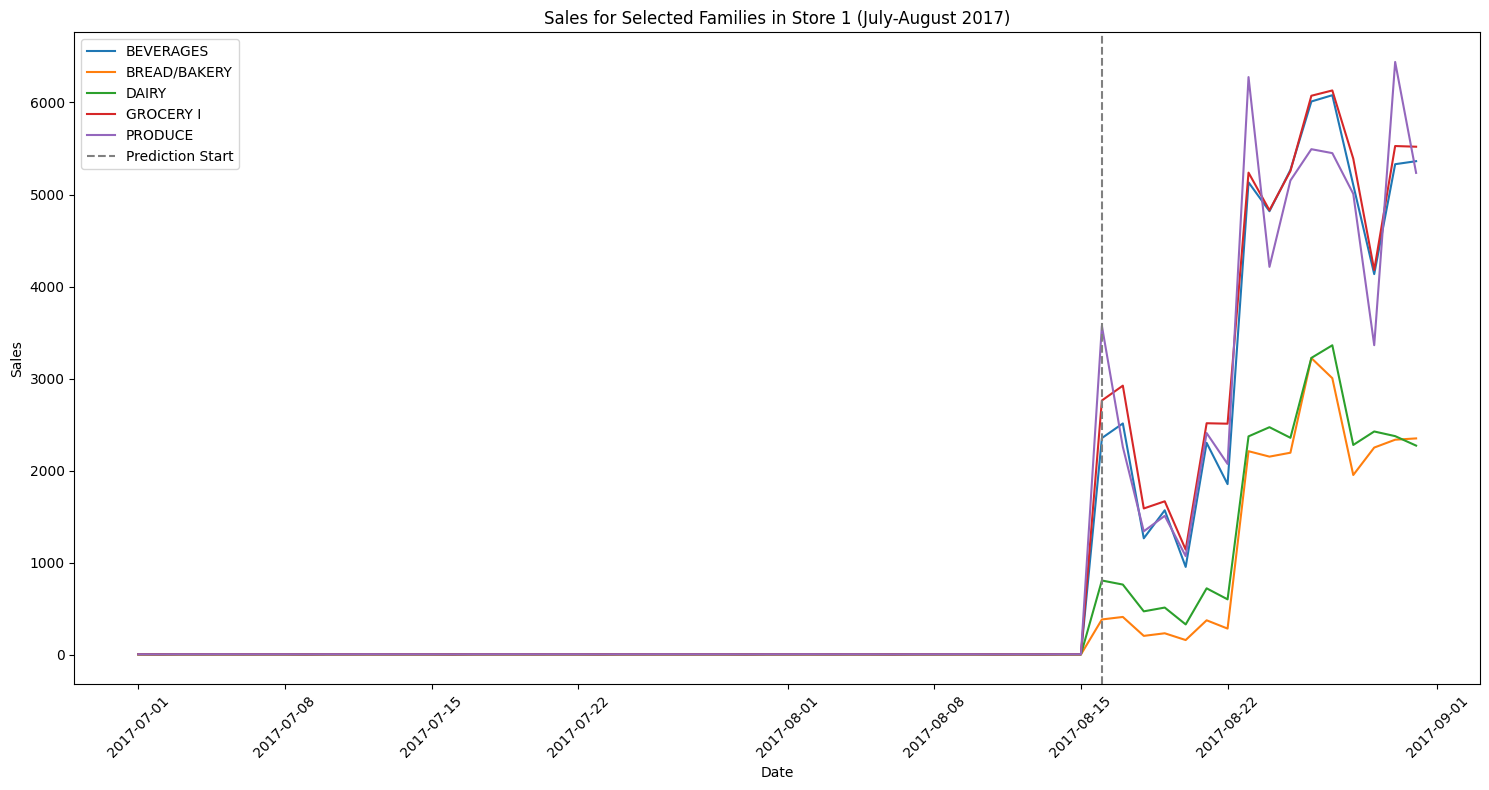

In [ ]:
# Combine val_merged and test_part1_merged for visualization
combined_data = pd.concat([val_merged, test_part1_merged,test_part2_merged], ignore_index=True)

# Define the date range and store number
start_date = '2017-07-01'
end_date = '2017-08-31'
store_number = 1

# Filter data for the specified store and date range
store_1_data_2017 = combined_data[
    (combined_data['store_nbr_encoded'] == store_number -1) &
    (combined_data['date'] >= start_date) &
    (combined_data['date'] <= end_date)
].copy()

# Select 5 families excluding 'CLEANING'
# You can replace this list with any 5 families you want to visualize
selected_families_names = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'DAIRY', 'BREAD/BAKERY'] # Example families

# Convert selected family names back to their encoded representation
selected_families_encoded = family_le.transform(selected_families_names)

# Filter the data to include only the selected families
store_1_data_2017_filtered = store_1_data_2017[store_1_data_2017['family_encoded'].isin(selected_families_encoded)].copy()


# Map encoded family names back to original family names for plotting
# Assuming 'family_le' (LabelEncoder) is still available from previous steps
store_1_data_2017_filtered['family'] = family_le.inverse_transform(store_1_data_2017_filtered['family_encoded'])


# Plotting the sales for selected families in store 1
plt.figure(figsize=(15, 8))
sns.lineplot(data=store_1_data_2017_filtered, x='date', y='sales', hue='family')
plt.title(f'Sales for Selected Families in Store {store_number} (July-August 2017)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)

# Add a vertical line to indicate the start of the prediction period
prediction_start_date = pd.to_datetime('2017-08-16')
plt.axvline(prediction_start_date, color='gray', linestyle='--', label='Prediction Start')

plt.legend()
plt.tight_layout()
plt.show()